<a href="https://colab.research.google.com/github/ynaloisp/Accenture2A_Project/blob/main/AccentureA_Clean_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Load Data

In this section, we **import the pump sensor dataset** for *predictive maintenance*.  

The dataset contains time-series readings such as:  
- *Throughput* (`pump_throughput_m3ph`)  
- *Operating pressure* (`operating_pressure_bar`)  
- *Vibration* (`vibration_mm_s`)  
- *Bearing temperature* (`bearing_temp_C`)  
- *Operating status* (`status`)  

<br>

<span style="color:red"> We will first inspect the dataset’s dimensions and structure to understand what we are working with.</span>


In [ ]:
# ★★ Import Libraries ★★

# ★ Data manipulation and analysis ★
import pandas as pd   # for handling tabular data (DataFrames, CSVs, time-series)
import numpy as np    # for numerical operations, arrays, math functions

# ★ Visualization ★
import matplotlib.pyplot as plt   # base plotting library (line plots, scatter, histograms, etc.)
import seaborn as sns             # high-level visualization built on matplotlib (prettier, easier stats plots)



In [ ]:
# Replace with your actual Google Sheet ID
sheet_id = "1ViF3WBQak9yVj5W-sS4NcaaUG6-pvsLhqE__wbWzxDw"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv"

df = pd.read_csv(url)
print("Dataset shape:", df.shape)
print(f"The dataset contains {df.shape[0]:,} rows and {df.shape[1]} columns.")
display(df.head())


Dataset shape: (720050, 7)
The dataset contains 720,050 rows and 7 columns.


timestamp  pump_throughput_m3ph  operating_pressure_bar  \
0  2025-04-15 20:14:00            101.948189                9.911733   
1  2025-04-15 20:24:00             97.350999               10.015090   
2  2025-04-15 20:34:00             98.642862                9.890661   
3  2025-04-15 20:44:00            101.125591               10.136244   
4  2025-04-15 20:54:00            102.167705               10.048706   

   vibration_mm_s  bearing_temp_C   status  pump_number  
0        1.151807       63.317134  RUNNING            1  
1        1.222389       67.622323  RUNNING            1  
2        1.284898       67.834281  RUNNING            1  
3        1.010065       64.876550  RUNNING            1  
4        0.981551       69.590331  RUNNING            1

# 2. Data Quality & Cleaning  

To build a reliable model, the dataset needs to be clean and consistent with the project goal of predicting pump failures from time-series sensor data.  

---

## Why Cleaning Matters  
- Labels (`status`: RUNNING, FAILING, FAILED) should be correct.  
- Sensor readings (throughput, vibration, pressure, temperature) should fall within realistic ranges and be as complete as possible.  
- Timestamps must be valid so failure patterns can be tracked.  

If these elements are messy, the model may pick up misleading signals and give poor predictions.  

---

## Cleaning Steps  
1. Drop unnecessary columns  
2. Handle missing values  
3. Fix data types (datetime, categorical)  
4. Standardize category labels (e.g., status)  
5. Identify or remove outliers  
6. Check timestamp consistency  

---

The goal is to prepare data that allows us to anticipate pump failures before they occur.  


In [ ]:
# Inspect dataset types & non-null counts
print(f"Dataset shape: {df.shape}")
df.info()
df['status'].unique()


Dataset shape: (720050, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720050 entries, 0 to 720049
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   timestamp               720050 non-null  object 
 1   pump_throughput_m3ph    720050 non-null  float64
 2   operating_pressure_bar  720050 non-null  float64
 3   vibration_mm_s          720050 non-null  float64
 4   bearing_temp_C          720050 non-null  float64
 5   status                  720050 non-null  object 
 6   pump_number             720050 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 38.5+ MB


array(['RUNNING', 'DOWN'], dtype=object)

In [ ]:
# --- Quick Intake Summary (for grading/reporting) ---
summary = {
    "rows": df.shape[0],
    "columns": df.shape[1],
    "column_dtypes": df.dtypes.astype(str).to_dict(),
    "numeric_columns": df.select_dtypes(include=["number"]).columns.tolist(),
    "non_numeric_columns": df.select_dtypes(exclude=["number"]).columns.tolist(),
}

print("Dataset summary")
print("Dataset shape:", df.shape)
print("\nNumeric columns:", df.select_dtypes(include='number').columns.tolist())
print("Non-numeric columns:", df.select_dtypes(exclude='number').columns.tolist())
print("\nDtypes:\n", df.dtypes)


Dataset summary
Dataset shape: (720050, 7)

Numeric columns: ['pump_throughput_m3ph', 'operating_pressure_bar', 'vibration_mm_s', 'bearing_temp_C', 'pump_number']
Non-numeric columns: ['timestamp', 'status']

Dtypes:
 timestamp                  object
pump_throughput_m3ph      float64
operating_pressure_bar    float64
vibration_mm_s            float64
bearing_temp_C            float64
status                     object
pump_number                 int64
dtype: object


In [ ]:
# PART 1: Parse timestamp & standardize status to {RUNNING, DOWN}
import numpy as np
import pandas as pd

# 1) timestamp → datetime
print("Converting 'timestamp' to datetime ...")
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
bad_ts = df['timestamp'].isna().sum()
print(f"  • timestamps that could not be parsed (NaT): {bad_ts}")

# 2) status cleanup → force exactly two classes
print("\nNormalizing 'status' labels to {RUNNING, DOWN} ...")

# normalize text
status_raw = df['status'].astype(str).str.strip().str.upper()

# map only known variants
status_map = {
    'RUN': 'RUNNING', 'RUNNING': 'RUNNING', 'UP': 'RUNNING',
    'DOWN': 'DOWN', 'FAIL': 'DOWN', 'FAILED': 'DOWN', 'FAILING': 'DOWN',
    'STOP': 'DOWN', 'STOPPED': 'DOWN', 'OFF': 'DOWN', 'ERROR': 'DOWN'
}
df['status'] = status_raw.map(status_map)

unexpected_mask = df['status'].isna()
if unexpected_mask.any():
    print("\n Unexpected status labels found (dropped):")
    print(status_raw[unexpected_mask].value_counts())
    df = df[~unexpected_mask].copy()

# lock to exactly two categories and remove any leftovers
df['status'] = pd.Categorical(df['status'], categories=['RUNNING', 'DOWN'], ordered=True)
df['status'] = df['status'].cat.remove_unused_categories()

# 3) (optional) drop rows with NaT timestamps — usually best in time-series
if bad_ts > 0:
    before = len(df)
    df = df.dropna(subset=['timestamp']).copy()
    print(f"  • dropped {before - len(df)} rows with NaT timestamps")

# Sanity checks
print("\nDtype check after parsing:")
print(df.dtypes)

print("\nStatus distribution (should be only RUNNING and DOWN):")
print(df['status'].value_counts(dropna=False))

print("\nSample rows (timestamp + status):")
display(df[['timestamp', 'status']].head())


Converting 'timestamp' to datetime ...
  • timestamps that could not be parsed (NaT): 1

Normalizing 'status' labels to {RUNNING, DOWN} ...
  • dropped 1 rows with NaT timestamps

Dtype check after parsing:
timestamp                 datetime64[ns]
pump_throughput_m3ph             float64
operating_pressure_bar           float64
vibration_mm_s                   float64
bearing_temp_C                   float64
status                          category
pump_number                        int64
dtype: object

Status distribution (should be only RUNNING and DOWN):
status
RUNNING    671599
DOWN        48450
Name: count, dtype: int64

Sample rows (timestamp + status):


timestamp   status
0 2025-04-15 20:14:00  RUNNING
1 2025-04-15 20:24:00  RUNNING
2 2025-04-15 20:34:00  RUNNING
3 2025-04-15 20:44:00  RUNNING
4 2025-04-15 20:54:00  RUNNING

In [ ]:
#Check missing values across dataset
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
timestamp                 0
pump_throughput_m3ph      0
operating_pressure_bar    0
vibration_mm_s            0
bearing_temp_C            0
status                    0
pump_number               0
dtype: int64


In [ ]:
# Check for duplicate rows
dup_count = df.duplicated().sum()
print(f"Total duplicate rows in dataset: {dup_count}")

Total duplicate rows in dataset: 0


In [ ]:
# Outlier & Range Checks
sensor_cols = ["pump_throughput_m3ph",
               "operating_pressure_bar",
               "vibration_mm_s",
               "bearing_temp_C"]

# 1) Quick min/max for each sensor column
print("Sensor value ranges:")
print(df[sensor_cols].agg(['min','max','mean']).T)

# 2) Count how many negative values exist (usually unrealistic for sensors like throughput, temp, etc.)
print("\nNegative value counts:")S
print((df[sensor_cols] < 0).sum())

# 3) Use describe() for a fuller statistical picture
print("\nSensor stats (5-number summary):")
display(df[sensor_cols].describe())


Sensor value ranges:
                              min         max       mean
pump_throughput_m3ph     0.000000  117.049782  93.156955
operating_pressure_bar   0.000000   12.047137   9.127802
vibration_mm_s           0.000000    3.241878   1.244188
bearing_temp_C          20.000154   96.225883  63.878193

Negative value counts:
pump_throughput_m3ph      0
operating_pressure_bar    0
vibration_mm_s            0
bearing_temp_C            0
dtype: int64

Sensor stats (5-number summary):


pump_throughput_m3ph  operating_pressure_bar  vibration_mm_s  \
count         720049.000000           720049.000000   720049.000000   
mean              93.156955                9.127802        1.244188   
std               25.236066                2.497119        0.473408   
min                0.000000                0.000000        0.000000   
25%               96.969295                9.383827        1.040612   
50%               99.567913                9.765682        1.291072   
75%              101.981651               10.093016        1.535483   
max              117.049782               12.047137        3.241878   

       bearing_temp_C  
count   720049.000000  
mean        63.878193  
std         11.645473  
min         20.000154  
25%         62.215597  
50%         66.091048  
75%         69.812714  
max         96.225883

In [ ]:
# === Outlier Checks & Handling (per pump, non-destructive) ===

sensor_cols = ["pump_throughput_m3ph",
               "operating_pressure_bar",
               "vibration_mm_s",
               "bearing_temp_C"]

# 1) Quick per-pump stats (useful to eyeball differences across pumps)
per_pump_stats = (
    df.groupby('pump_number')[sensor_cols]
      .describe(percentiles=[0.25, 0.5, 0.75])
)
print("Per-pump descriptive stats computed.")
# display(per_pump_stats.head())  # uncomment to view

# 2) Flag outliers per pump using IQR rule (1.5×IQR)
for col in sensor_cols:
    q = df.groupby('pump_number')[col].quantile([0.25, 0.75]).unstack()
    q.columns = ['q1', 'q3']
    q['iqr'] = q['q3'] - q['q1']
    q['low'] = q['q1'] - 1.5 * q['iqr']
    q['high'] = q['q3'] + 1.5 * q['iqr']

    # Map thresholds back to rows
    low_thr = df['pump_number'].map(q['low'])
    high_thr = df['pump_number'].map(q['high'])

    flag_col = f"{col}_is_outlier"
    df[flag_col] = (df[col] < low_thr) | (df[col] > high_thr)

# 3) Summaries
flag_cols = [f"{c}_is_outlier" for c in sensor_cols]
total_outliers = df[flag_cols].sum()
print("\nOutlier counts per sensor (IQR, per pump):")
print(total_outliers)

print("\nRows with any outlier (count):", df[flag_cols].any(axis=1).sum())

print("\nOutliers by status (rows with ANY outlier):")
print(
    df.assign(any_outlier=df[flag_cols].any(axis=1))
      .groupby(['status'])['any_outlier']
      .sum()
)

# 4) Peek at a few outlier rows
print("\nSample rows with any outlier:")
display(
    df.loc[df[flag_cols].any(axis=1),
           ['timestamp','pump_number','status'] + sensor_cols + flag_cols]
      .head(10)
)

# --- Optional: create capped ("winsorized") versions for modeling later ---
# from numpy import clip
# for col in sensor_cols:
#     flag = f"{col}_is_outlier"
#     q = df.groupby('pump_number')[col].quantile([0.25, 0.75]).unstack()
#     q.columns = ['q1', 'q3']
#     iqr = q['q3'] - q['q1']
#     low = df['pump_number'].map(q['q1'] - 1.5*iqr)
#     high = df['pump_number'].map(q['q3'] + 1.5*iqr)
#     df[f"{col}_capped"] = clip(df[col], low, high)
# print("\nOptional capped features created (commented out by default).")


Per-pump descriptive stats computed.

Outlier counts per sensor (IQR, per pump):
pump_throughput_m3ph_is_outlier      50771
operating_pressure_bar_is_outlier    52471
vibration_mm_s_is_outlier            53488
bearing_temp_C_is_outlier            52512
dtype: int64

Rows with any outlier (count): 63633

Outliers by status (rows with ANY outlier):
status
RUNNING    15183
DOWN       48450
Name: any_outlier, dtype: int64

Sample rows with any outlier:


/tmp/ipython-input-1042839993.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['status'])['any_outlier']


timestamp  pump_number   status  pump_throughput_m3ph  \
197 2025-04-17 05:04:00            1  RUNNING            110.968137   
198 2025-04-17 05:14:00            1  RUNNING            110.935935   
200 2025-04-17 05:34:00            1  RUNNING            110.584761   
418 2025-04-18 17:54:00            1  RUNNING             94.491559   
530 2025-04-19 12:34:00            1  RUNNING             99.709469   
679 2025-04-20 13:24:00            1  RUNNING            103.113514   
706 2025-04-20 17:54:00            1  RUNNING            101.294046   
901 2025-04-22 02:24:00            1  RUNNING             97.085681   
916 2025-04-22 04:54:00            1  RUNNING             95.103892   
917 2025-04-22 05:04:00            1  RUNNING             95.902402   

     operating_pressure_bar  vibration_mm_s  bearing_temp_C  \
197               10.199535        0.887580       72.251567   
198               10.548499        1.031885       65.076208   
200               10.808030        0.921876       65.039648   
418               10.348444        1.209002       82.429876   
530                8.240971        1.712951       64.429459   
679                9.726405        2.344418       64.516351   
706                9.625194        1.403659       50.011631   
901               11.192763        1.240483       72.915643   
916                8.337486        1.560475       64.738419   
917                8.050185        1.919317       65.988912   

     pump_throughput_m3ph_is_outlier  operating_pressure_bar_is_outlier  \
197                             True                              False   
198                             True                              False   
200                             True                              False   
418                            False                              False   
530                            False                               True   
679                            False                              False   
706                            False                              False   
901                            False                               True   
916                            False                               True   
917                            False                               True   

     vibration_mm_s_is_outlier  bearing_temp_C_is_outlier  
197                      False                      False  
198                      False                      False  
200                      False                      False  
418                      False                       True  
530                      False                      False  
679                       True                      False  
706                      False                       True  
901                      False                      False  
916                      False                      False  
917                      False                      False

In [ ]:
# === Time Ordering & Duplicate Check ===

# 1) Confirm timestamps are sorted per pump
is_sorted = df.groupby('pump_number')['timestamp'].apply(lambda x: x.is_monotonic_increasing).all()
print("Are timestamps sorted within each pump? →", is_sorted)

# 2) Find duplicates (pump + timestamp)
dup_ts_count = df.duplicated(subset=['pump_number','timestamp']).sum()
print("Number of duplicate rows (pump + timestamp):", dup_ts_count)

# 3) If unsorted, sort dataset by pump + timestamp
if not is_sorted:
    df = df.sort_values(by=['pump_number','timestamp']).reset_index(drop=True)
    print("Dataset was not sorted — now sorted chronologically within pumps.")

# 4) Drop duplicates if needed
if dup_ts_count > 0:
    before = len(df)
    df = df.drop_duplicates(subset=['pump_number','timestamp']).copy()
    print(f"Dropped {before - len(df)} duplicate rows.")

# 5) Sanity check
print("\nFirst 5 timestamps:")
print(df[['pump_number','timestamp']].head())
print("\nLast 5 timestamps:")
print(df[['pump_number','timestamp']].tail())


Are timestamps sorted within each pump? → True
Number of duplicate rows (pump + timestamp): 0

First 5 timestamps:
   pump_number           timestamp
0            1 2025-04-15 20:14:00
1            1 2025-04-15 20:24:00
2            1 2025-04-15 20:34:00
3            1 2025-04-15 20:44:00
4            1 2025-04-15 20:54:00

Last 5 timestamps:
        pump_number           timestamp
720044           50 2025-07-24 19:24:00
720045           50 2025-07-24 19:34:00
720046           50 2025-07-24 19:44:00
720047           50 2025-07-24 19:54:00
720048           50 2025-07-24 20:04:00


In [ ]:
# === Check logging interval consistency per pump ===

# 1) Calculate time differences per pump
df['time_diff'] = df.groupby('pump_number')['timestamp'].diff().dt.total_seconds() / 60

# 2) Summary of intervals
print("Time interval summary (minutes):")
print(df['time_diff'].describe())

# 3) Most common interval
mode_interval = df['time_diff'].mode()[0]
print(f"\nMost common logging interval: {mode_interval:.2f} minutes")

# 4) Anomaly checks
print(f"Zero-interval rows (duplicates): {(df['time_diff'] == 0).sum()}")
print(f"Unusually large gaps (> 2× normal): {(df['time_diff'] > 2 * mode_interval).sum()}")

# 5) Drop helper column (not needed for modeling)
df = df.drop(columns=['time_diff'])


Time interval summary (minutes):
count    719999.0
mean         10.0
std           0.0
min          10.0
25%          10.0
50%          10.0
75%          10.0
max          10.0
Name: time_diff, dtype: float64

Most common logging interval: 10.00 minutes
Zero-interval rows (duplicates): 0
Unusually large gaps (> 2× normal): 0


In [ ]:
# === Duplicate Timestamp Checks ===

# 1) Check duplicates at the pump level (timestamp + pump_number)
dups_within_pump = df.duplicated(subset=['pump_number', 'timestamp'])
print("Duplicate rows (same pump + same timestamp):", dups_within_pump.sum())

if dups_within_pump.any():
    print("\nExample duplicate rows within a pump:")
    display(df[dups_within_pump].head(10))

# 2) Check duplicates only at timestamp level (across all pumps)
# Note: This is expected since multiple pumps log at the same time
dup_counts = df['timestamp'].value_counts()
multi_pump_timestamps = (dup_counts > 1).sum()
print(f"\nTimestamps shared by multiple pumps (expected): {multi_pump_timestamps}")

# 3) Optional: show a sample of "multi-pump" timestamps
sample_multi = dup_counts[dup_counts > 1].head(3).index
print("\nSample timestamps shared across pumps:")
for ts in sample_multi:
    display(df[df['timestamp'] == ts].head(10))


Duplicate rows (same pump + same timestamp): 0

Timestamps shared by multiple pumps (expected): 14401

Sample timestamps shared across pumps:


timestamp  pump_throughput_m3ph  operating_pressure_bar  \
14383  2025-07-24 17:24:00             94.122575                9.093015   
28784  2025-07-24 17:24:00            101.983061                9.922847   
43185  2025-07-24 17:24:00             90.928548                9.058122   
57586  2025-07-24 17:24:00             95.387462               10.676099   
71987  2025-07-24 17:24:00             97.284901               10.126526   
86388  2025-07-24 17:24:00             92.345470                9.683234   
100789 2025-07-24 17:24:00            105.538775                9.756099   
115190 2025-07-24 17:24:00             98.013744                9.657827   
129591 2025-07-24 17:24:00            100.268618               10.480036   
143992 2025-07-24 17:24:00            103.025092                9.562998   

        vibration_mm_s  bearing_temp_C   status  pump_number  \
14383         1.619852       65.401924  RUNNING            1   
28784         0.984082       74.999789  RUNNING            2   
43185         1.726745       69.668271  RUNNING            3   
57586         1.379612       63.068251  RUNNING            4   
71987         1.147674       67.814402  RUNNING            5   
86388         1.184238       73.070933  RUNNING            6   
100789        1.147173       71.096842  RUNNING            7   
115190        1.709331       61.079488  RUNNING            8   
129591        1.251922       68.036554  RUNNING            9   
143992        1.465949       58.779772  RUNNING           10   

        pump_throughput_m3ph_is_outlier  operating_pressure_bar_is_outlier  \
14383                             False                              False   
28784                             False                              False   
43185                             False                              False   
57586                             False                              False   
71987                             False                              False   
86388                             False                              False   
100789                            False                              False   
115190                            False                              False   
129591                            False                              False   
143992                            False                              False   

        vibration_mm_s_is_outlier  bearing_temp_C_is_outlier  
14383                       False                      False  
28784                       False                      False  
43185                       False                      False  
57586                       False                      False  
71987                       False                      False  
86388                       False                      False  
100789                      False                      False  
115190                      False                      False  
129591                      False                      False  
143992                      False                      False

timestamp  pump_throughput_m3ph  operating_pressure_bar  \
14382  2025-07-24 17:14:00             91.504851                9.727506   
28783  2025-07-24 17:14:00            102.660199               10.171200   
43184  2025-07-24 17:14:00             89.403407                9.539857   
57585  2025-07-24 17:14:00             91.711525               10.273065   
71986  2025-07-24 17:14:00             99.247884                9.784608   
86387  2025-07-24 17:14:00             96.179781               10.100446   
100788 2025-07-24 17:14:00            102.175133                9.751879   
115189 2025-07-24 17:14:00             97.373212                9.778681   
129590 2025-07-24 17:14:00             99.045185               10.249699   
143991 2025-07-24 17:14:00             98.876100                9.347447   

        vibration_mm_s  bearing_temp_C   status  pump_number  \
14382         1.673767       65.232277  RUNNING            1   
28783         0.810298       69.935282  RUNNING            2   
43184         1.579444       67.839249  RUNNING            3   
57585         1.337272       64.430761  RUNNING            4   
71986         1.164499       66.051571  RUNNING            5   
86387         1.116383       70.737691  RUNNING            6   
100788        1.253886       64.819630  RUNNING            7   
115189        1.724023       62.194236  RUNNING            8   
129590        1.318674       61.054921  RUNNING            9   
143991        1.500876       67.804412  RUNNING           10   

        pump_throughput_m3ph_is_outlier  operating_pressure_bar_is_outlier  \
14382                             False                              False   
28783                             False                              False   
43184                              True                              False   
57585                             False                              False   
71986                             False                              False   
86387                             False                              False   
100788                            False                              False   
115189                            False                              False   
129590                            False                              False   
143991                            False                              False   

        vibration_mm_s_is_outlier  bearing_temp_C_is_outlier  
14382                       False                      False  
28783                       False                      False  
43184                       False                      False  
57585                       False                      False  
71986                       False                      False  
86387                       False                      False  
100788                      False                      False  
115189                      False                      False  
129590                      False                      False  
143991                      False                      False

timestamp  pump_throughput_m3ph  operating_pressure_bar  \
14381  2025-07-24 17:04:00             94.837487                9.222918   
28782  2025-07-24 17:04:00            106.252259               10.320145   
43183  2025-07-24 17:04:00             92.484967                9.502190   
57584  2025-07-24 17:04:00             89.364287               10.670140   
71985  2025-07-24 17:04:00            103.093791                9.692527   
86386  2025-07-24 17:04:00            100.364435               10.103989   
100787 2025-07-24 17:04:00              0.000000                0.000000   
115188 2025-07-24 17:04:00            103.161669                9.784848   
129589 2025-07-24 17:04:00             98.579131               10.209637   
143990 2025-07-24 17:04:00            101.942107                9.430081   

        vibration_mm_s  bearing_temp_C   status  pump_number  \
14381         1.770881       70.067024  RUNNING            1   
28782         0.817305       75.506278  RUNNING            2   
43183         1.334947       65.975124  RUNNING            3   
57584         1.500397       65.726000  RUNNING            4   
71985         1.285003       67.033288  RUNNING            5   
86386         0.906270       70.306321  RUNNING            6   
100787        0.000000       21.968448     DOWN            7   
115188        1.207711       68.546265  RUNNING            8   
129589        1.509922       63.851589  RUNNING            9   
143990        1.846768       70.400243  RUNNING           10   

        pump_throughput_m3ph_is_outlier  operating_pressure_bar_is_outlier  \
14381                             False                              False   
28782                             False                              False   
43183                             False                              False   
57584                              True                              False   
71985                             False                              False   
86386                             False                              False   
100787                             True                               True   
115188                            False                              False   
129589                            False                              False   
143990                            False                              False   

        vibration_mm_s_is_outlier  bearing_temp_C_is_outlier  
14381                       False                      False  
28782                       False                      False  
43183                       False                      False  
57584                       False                      False  
71985                       False                      False  
86386                       False                      False  
100787                       True                       True  
115188                      False                      False  
129589                      False                      False  
143990                      False                      False

In [ ]:
# Check if (timestamp, pump_number) pairs are unique
pair_dupes = df.duplicated(subset=['timestamp', 'pump_number'])

# Count them
print("Number of duplicate (timestamp, pump_number) pairs:", pair_dupes.sum())

# Show a few example rows if they exist
if pair_dupes.any():
    display(df.loc[pair_dupes].head(10))
else:
    print("No duplicate (timestamp, pump_number) pairs found ")


Number of duplicate (timestamp, pump_number) pairs: 0
No duplicate (timestamp, pump_number) pairs found 


Data Cleaning Summary

We cleaned the pump dataset to make sure it’s accurate, consistent, and ready for analysis. Here’s what we did:

Converted timestamps into proper datetime format and ordered the data chronologically.

Standardized the status column into two values only: RUNNING and DOWN.

Found and removed 1 row with a missing timestamp.

Checked for duplicate (timestamp, pump_number) pairs — none were found.

Verified sensor ranges (throughput, pressure, vibration, temperature) — no negatives or impossible values.

Confirmed that logging intervals are consistent at 10 minutes.

We also flagged potential outliers in throughput, pressure, vibration, and temperature. These will be reviewed later to decide if they’re errors or valuable signals of unusual pump behavior.

Flagged about 9% of rows with outlier sensor readings (most when pumps were DOWN, some while RUNNING).

Bottom line: The dataset is now clean, reliable, and structured for exploratory analysis and predictive modeling.

# 3. Exploratory Data Analysis (EDA)

Now that the dataset is cleaned and standardized (`RUNNING` vs `DOWN`), we begin Exploratory Data Analysis.  
The goal of EDA is to **understand the data’s structure, distributions, and relationships** before modeling.  

For predictive maintenance, EDA helps us answer:
- How balanced are the labels (`RUNNING` vs `DOWN`)?  
- What are the operating ranges for throughput, pressure, vibration, and temperature?  
- Do sensor readings differ between `RUNNING` and `DOWN` states?  
- Are there correlations between sensors that may guide feature engineering?  

Class balance (counts):
status
RUNNING    671599
DOWN        48450
Name: count, dtype: int64

Class balance (%):
status
RUNNING    93.27
DOWN        6.73
Name: proportion, dtype: float64


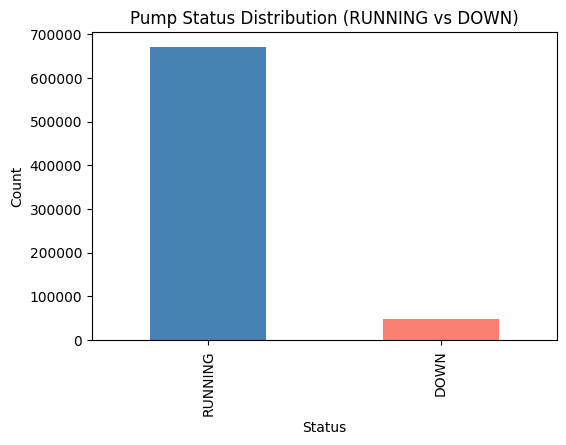

In [ ]:
# @title
# --- Status distribution ---
status_counts = df['status'].value_counts()
status_pct = df['status'].value_counts(normalize=True) * 100

print("Class balance (counts):")
print(status_counts)
print("\nClass balance (%):")
print(status_pct.round(2))

status_counts.plot(kind='bar', color=['steelblue','salmon'], figsize=(6,4))
plt.title("Pump Status Distribution (RUNNING vs DOWN)")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()


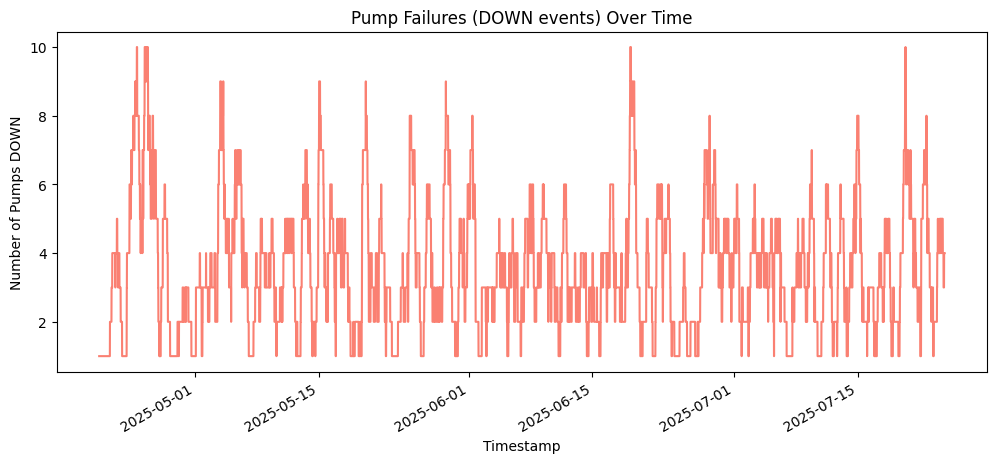

In [ ]:
# @title
# --- DOWN events over time ---

# Filter only DOWN events
down_events = df[df['status'] == 'DOWN']

# Count how many pumps are DOWN per timestamp
down_counts = down_events.groupby('timestamp').size()

# Plot
plt.figure(figsize=(12,5))
down_counts.plot(color='salmon')

plt.title("Pump Failures (DOWN events) Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Number of Pumps DOWN")
plt.show()


<span style="color:#ab7dad;"><i>Pump failure events fluctuate consistently across the observed period, with frequent spikes reaching up to 9–10 simultaneous DOWN events, particularly in early May and mid-June. After mid-May, the number of concurrent failures stabilizes around 2–5 pumps at a time, indicating recurring but distributed failure patterns rather than a single clustered outage.</i></span>

---






In [ ]:
# @title
# --- Sensor descriptive stats ---
sensor_cols = ["pump_throughput_m3ph", "operating_pressure_bar",
               "vibration_mm_s", "bearing_temp_C"]

print("Sensor summary (RUNNING + DOWN combined):")
display(df[sensor_cols].describe().T)

print("\nPer-status means:")
display(df.groupby('status')[sensor_cols].mean().round(3))


Sensor summary (RUNNING + DOWN combined):


count       mean        std        min        25%  \
pump_throughput_m3ph    720049.0  93.156955  25.236066   0.000000  96.969295   
operating_pressure_bar  720049.0   9.127802   2.497119   0.000000   9.383827   
vibration_mm_s          720049.0   1.244188   0.473408   0.000000   1.040612   
bearing_temp_C          720049.0  63.878193  11.645473  20.000154  62.215597   

                              50%         75%         max  
pump_throughput_m3ph    99.567913  101.981651  117.049782  
operating_pressure_bar   9.765682   10.093016   12.047137  
vibration_mm_s           1.291072    1.535483    3.241878  
bearing_temp_C          66.091048   69.812714   96.225883


Per-status means:


/tmp/ipython-input-2751717341.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('status')[sensor_cols].mean().round(3))


pump_throughput_m3ph  operating_pressure_bar  vibration_mm_s  \
status                                                                  
RUNNING                99.877                   9.786           1.334   
DOWN                    0.000                   0.000           0.000   

         bearing_temp_C  
status                   
RUNNING          66.683  
DOWN             25.000

<span style="color:#ab7dad;"><i>During RUNNING periods, pumps average 99.88 m³/h throughput, 9.79 bar pressure, 1.33 mm/s vibration, and 66.68 °C bearing temperature, while DOWN periods show zero flow/pressure/vibration and a stable 25 °C bearing temperature. This is a clear operational vs. failure state distinction that can be leveraged for predictive features.</i></span>

---


Sensor summary (describe):


count       mean        std        min        25%  \
pump_throughput_m3ph    720049.0  93.156955  25.236066   0.000000  96.969295   
operating_pressure_bar  720049.0   9.127802   2.497119   0.000000   9.383827   
vibration_mm_s          720049.0   1.244188   0.473408   0.000000   1.040612   
bearing_temp_C          720049.0  63.878193  11.645473  20.000154  62.215597   

                              50%         75%         max       iqr  
pump_throughput_m3ph    99.567913  101.981651  117.049782  5.012356  
operating_pressure_bar   9.765682   10.093016   12.047137  0.709188  
vibration_mm_s           1.291072    1.535483    3.241878  0.494871  
bearing_temp_C          66.091048   69.812714   96.225883  7.597117

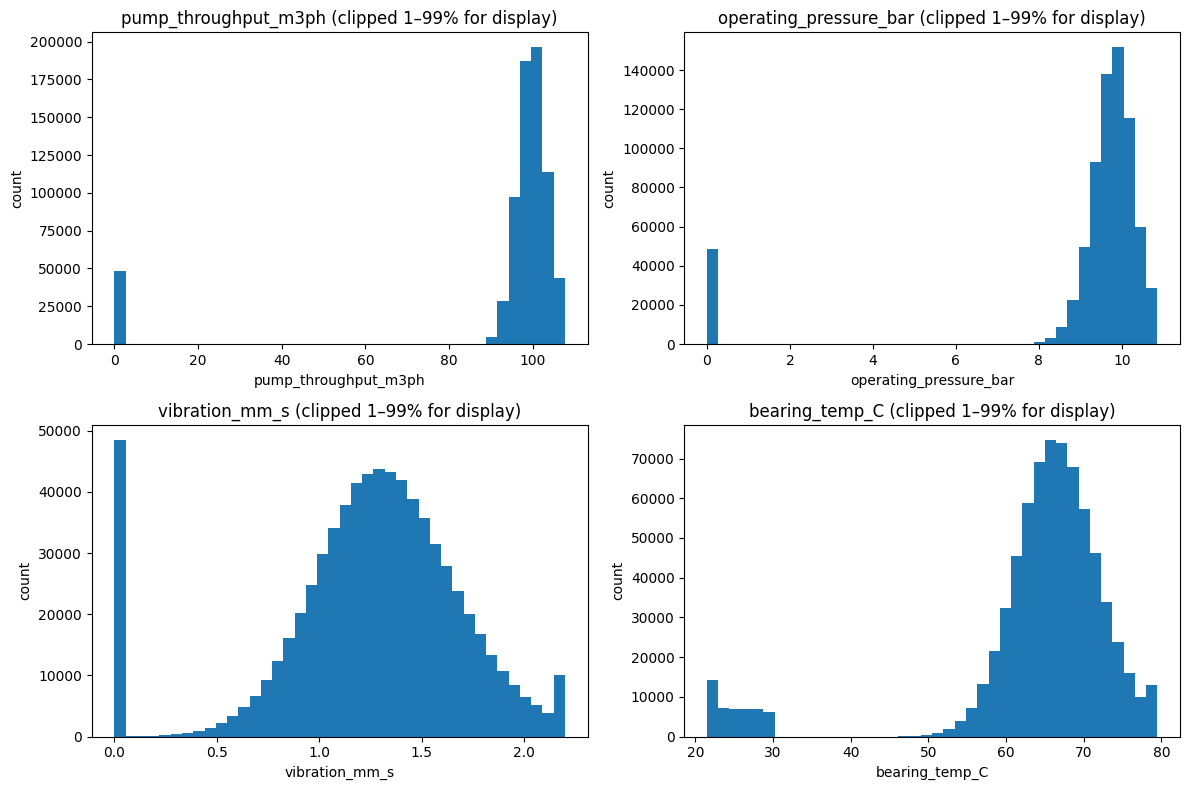

Rows -> RUNNING: 671,599 | DOWN: 48,450


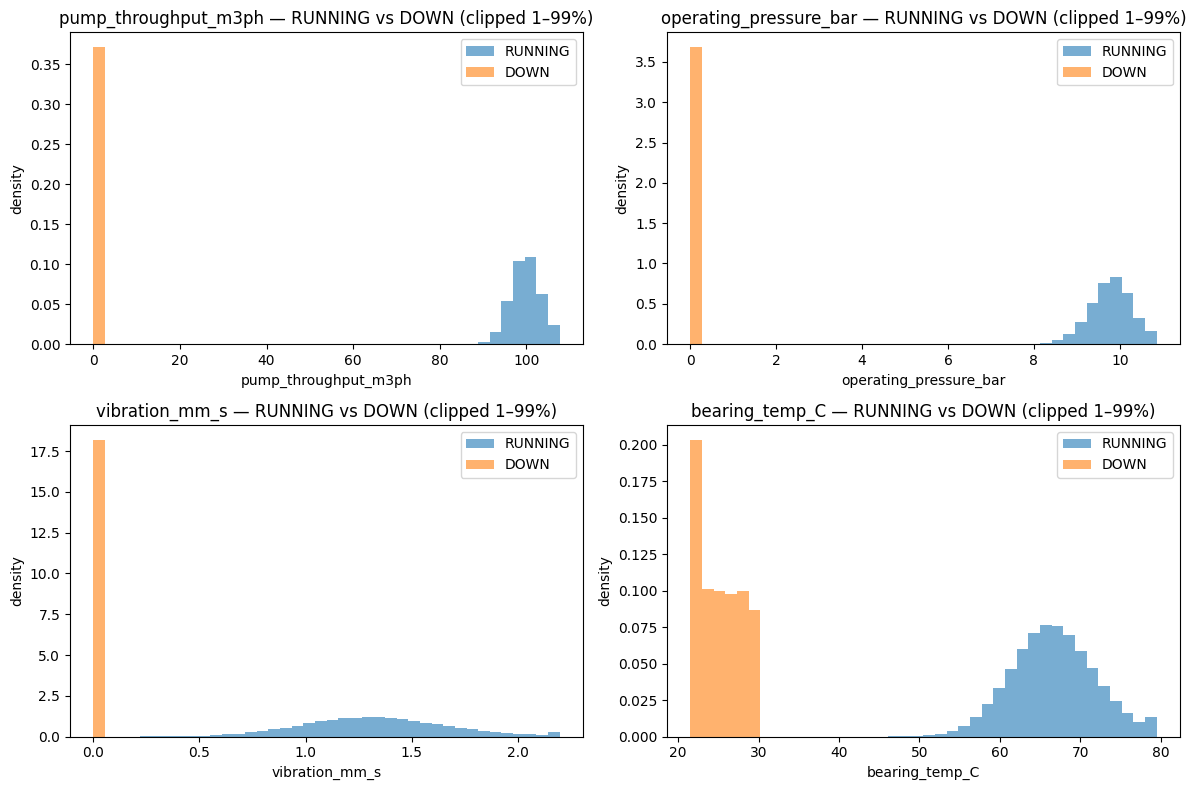


Per-status sensor means:


/tmp/ipython-input-303232915.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("status")[sensor_cols]


pump_throughput_m3ph  operating_pressure_bar  vibration_mm_s  \
status                                                                  
RUNNING                99.877                   9.786           1.334   
DOWN                    0.000                   0.000           0.000   

         bearing_temp_C  
status                   
RUNNING          66.683  
DOWN             25.000

In [ ]:
# @title
sensor_cols = ["pump_throughput_m3ph", "operating_pressure_bar",
               "vibration_mm_s", "bearing_temp_C"]
# --- 0) Guardrails: enforce exactly the two statuses we expect ---
expected_statuses = ["RUNNING", "DOWN"]
if set(pd.Series(df["status"]).dropna().astype(str).unique()) - set(expected_statuses):
    print("⚠️ Unexpected status labels remain in df['status']. "
          "Upstream cleanup cell should have removed them.")

# --- 1) Summary table for sensors ---
print("Sensor summary (describe):")
display(
    df[sensor_cols]
      .describe()
      .T.assign(iqr=lambda t: t["75%"] - t["25%"])[
          ["count","mean","std","min","25%","50%","75%","max","iqr"]
      ]
)

# --- 2) Histograms for each sensor (whole dataset) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for ax, col in zip(axes, sensor_cols):
    # Use central 1–99% just for visualization (prevents long tails from shrinking the view)
    lo, hi = df[col].quantile([0.01, 0.99])
    clipped = df[col].clip(lo, hi)
    ax.hist(clipped, bins=40)
    ax.set_title(f"{col} (clipped 1–99% for display)")
    ax.set_xlabel(col); ax.set_ylabel("count")
plt.tight_layout()
plt.show()

# --- 3) Compare RUNNING vs DOWN for each sensor ---
running = df[df["status"] == "RUNNING"]
down    = df[df["status"] == "DOWN"]

print(f"Rows -> RUNNING: {len(running):,} | DOWN: {len(down):,}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, col in zip(axes, sensor_cols):
    # Same clipping window + shared bins for fair comparison
    lo, hi = df[col].quantile([0.01, 0.99])
    bins = np.linspace(lo, hi, 41)

    # Plot only if the subset has data; avoids divide-by-zero warnings
    if len(running):
        ax.hist(running[col].clip(lo, hi), bins=bins, alpha=0.6, density=True, label="RUNNING")
    if len(down):
        ax.hist(down[col].clip(lo, hi), bins=bins, alpha=0.6, density=True, label="DOWN")

    ax.set_title(f"{col} — RUNNING vs DOWN (clipped 1–99%)")
    ax.set_xlabel(col); ax.set_ylabel("density")
    ax.legend()
plt.tight_layout()
plt.show()

# --- 4) Per-status means (quick numeric comparison) ---
print("\nPer-status sensor means:")
# Restrict to the two statuses explicitly to keep order stable
display(
    df[df["status"].isin(expected_statuses)]
      .groupby("status")[sensor_cols]
      .mean()
      .reindex(expected_statuses)
      .round(3)
)


<span style="color:#ab7dad;"><i>
Pump throughput and pressure concentrate tightly between roughly 95–105 m³/h and 9–10 bar, with a distinct spike at zero indicating failure events. Vibration follows a roughly normal distribution centered near 1.2 mm/s, with an additional zero spike for downtime. Bearing temperature displays two clear modes: a dominant operational peak around 60–70 °C and a smaller cluster near 20–25 °C. These distributions reveal both the stable operating bands of the pumps and the characteristic signal collapse during failure periods, which are ideal for feature engineering.
</i></span>
<br>
<br>
<span style="color:#ab7dad;"><i>
The density plots highlight the sharp separation between RUNNING (blue) and DOWN (orange) sensor behaviors. RUNNING data are tightly clustered in their normal operational ranges for all four sensors, while DOWN periods collapse entirely to zeros or ambient temperature levels. This clean separation provides strong evidence that sensor readings alone are sufficient to distinguish between operating and failed states, and deviations toward the DOWN distributions can be used as leading indicators for predictive maintenance models.
</i></span>

In [ ]:
# @title
# number of unique pumps
n_pumps = df['pump_number'].nunique()
print("Total pumps:", n_pumps)

# list of pump IDs
pump_ids = df['pump_number'].unique()
print("Pump IDs:", pump_ids)

# Count DOWN events per pump
down_events = df[df['status'] == 'DOWN'].groupby('pump_number').size()

print("DOWN events per pump:")
print(down_events)

# If you want to sort from most to least DOWN events:
down_events_sorted = down_events.sort_values(ascending=False)
print("\nSorted DOWN events per pump:")
print(down_events_sorted)

# Total number of DOWN events
print("\nTotal DOWN events:", down_events.sum())



Total pumps: 50
Pump IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
DOWN events per pump:
pump_number
1      965
2     1096
3      923
4      988
5      920
6      956
7      830
8      899
9      979
10     891
11     909
12    1007
13     882
14    1013
15    1033
16    1006
17     930
18    1075
19    1044
20    1028
21     995
22     910
23     902
24     961
25    1070
26     930
27     914
28    1048
29    1109
30     845
31     992
32     977
33    1006
34     925
35     870
36     944
37     963
38     983
39     994
40    1015
41     908
42     962
43     939
44     893
45     973
46    1001
47     871
48    1104
49    1008
50    1064
dtype: int64

Sorted DOWN events per pump:
pump_number
29    1109
48    1104
2     1096
18    1075
25    1070
50    1064
28    1048
19    1044
15    1033
20    1028
40    1015
14    1013
49    1008
12    1007
33    1006
16    1006
46   

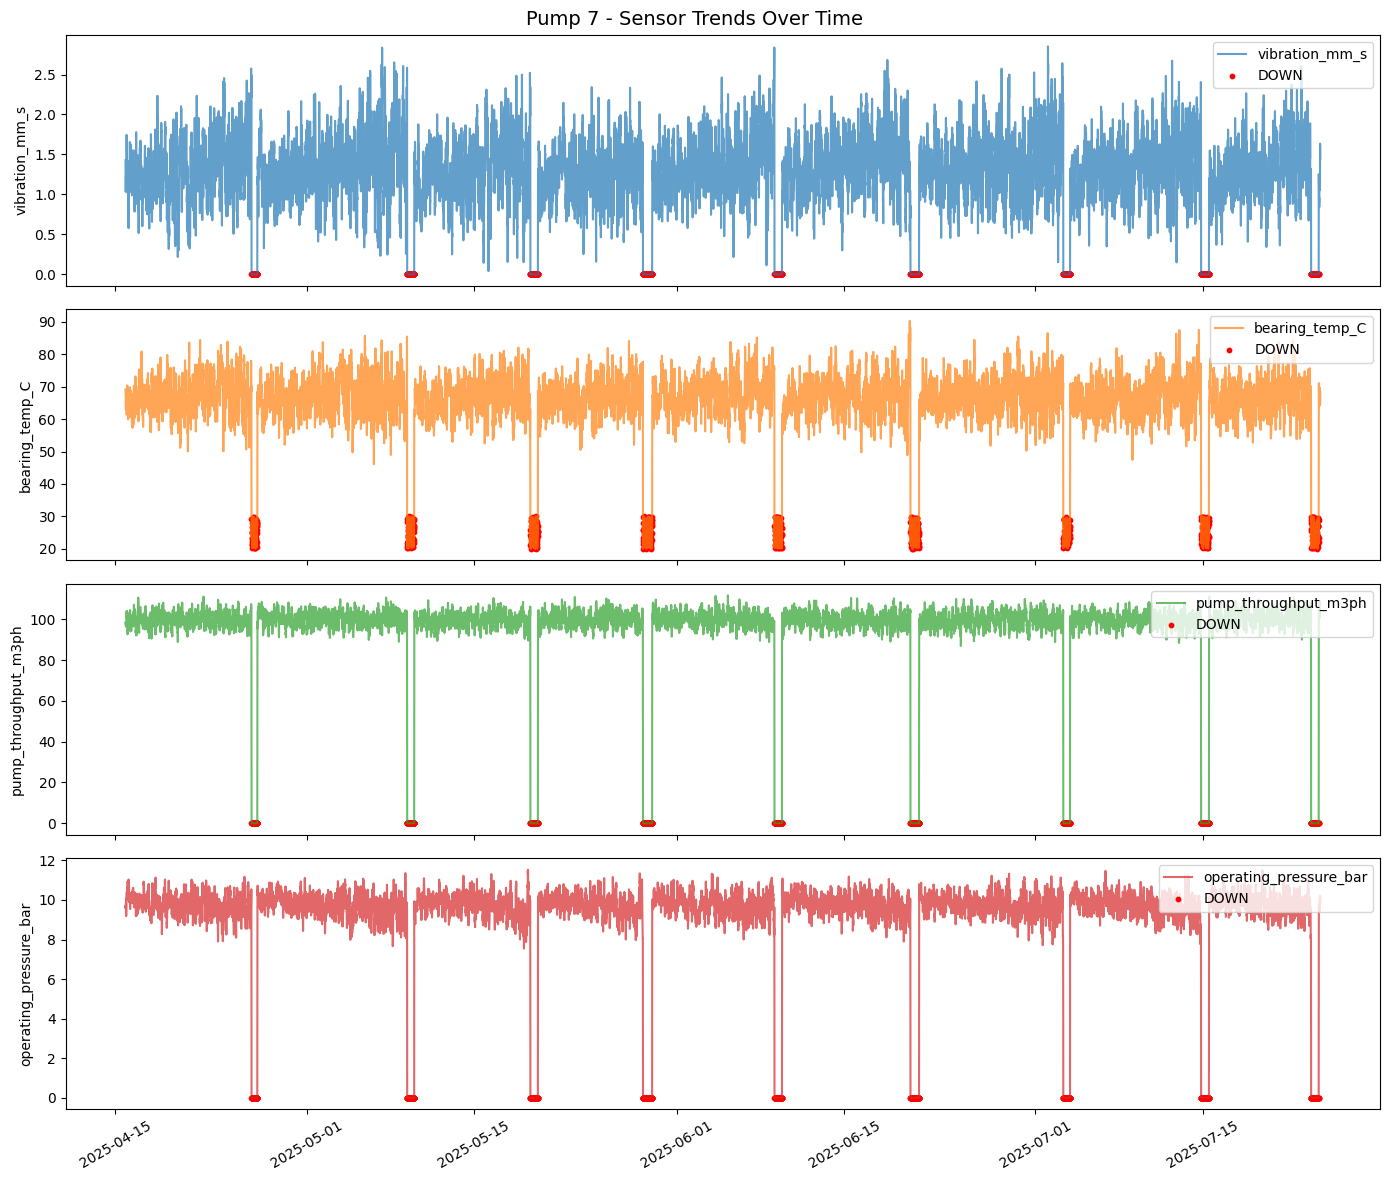

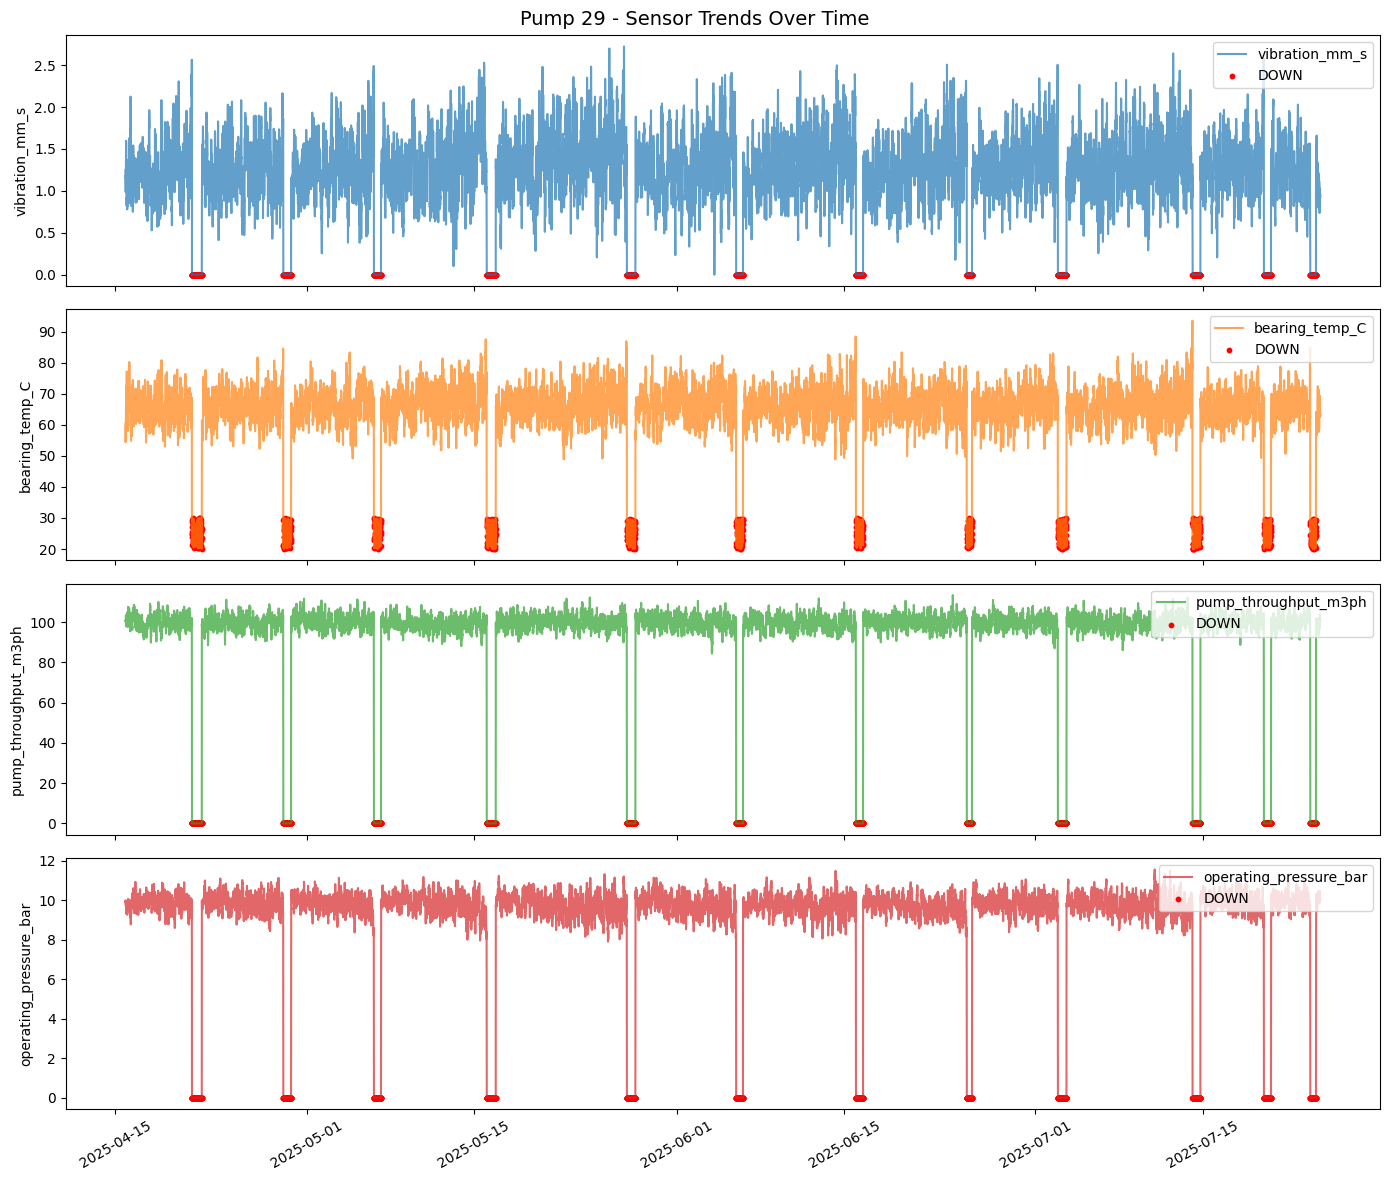

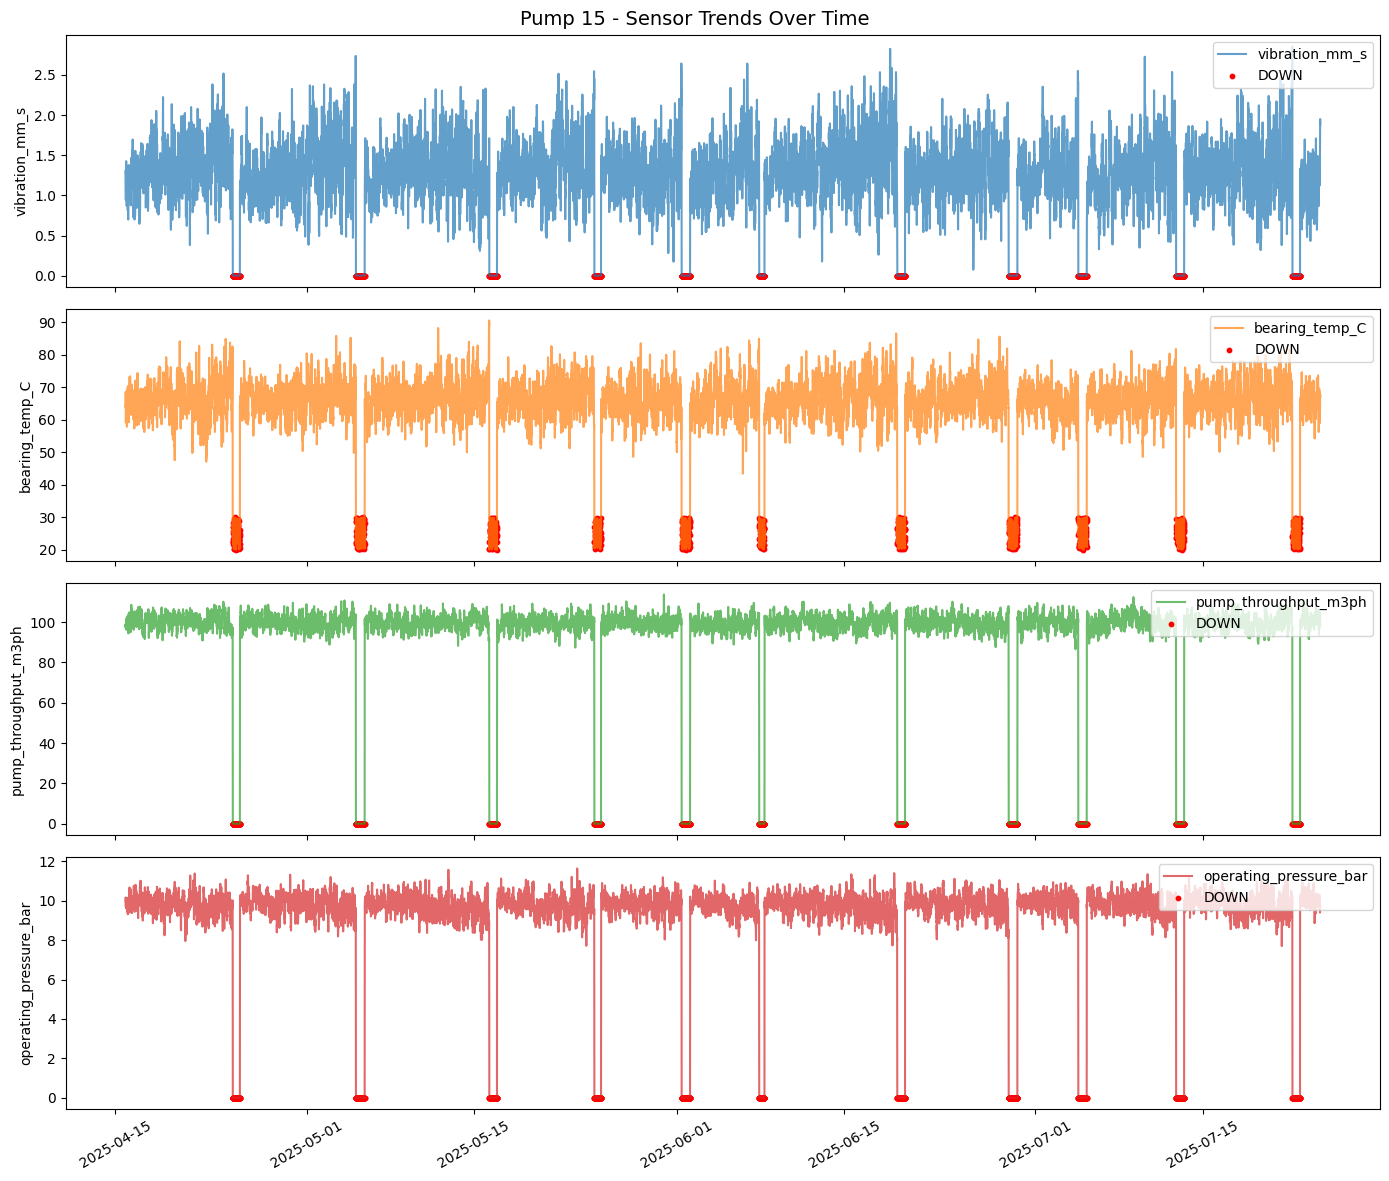

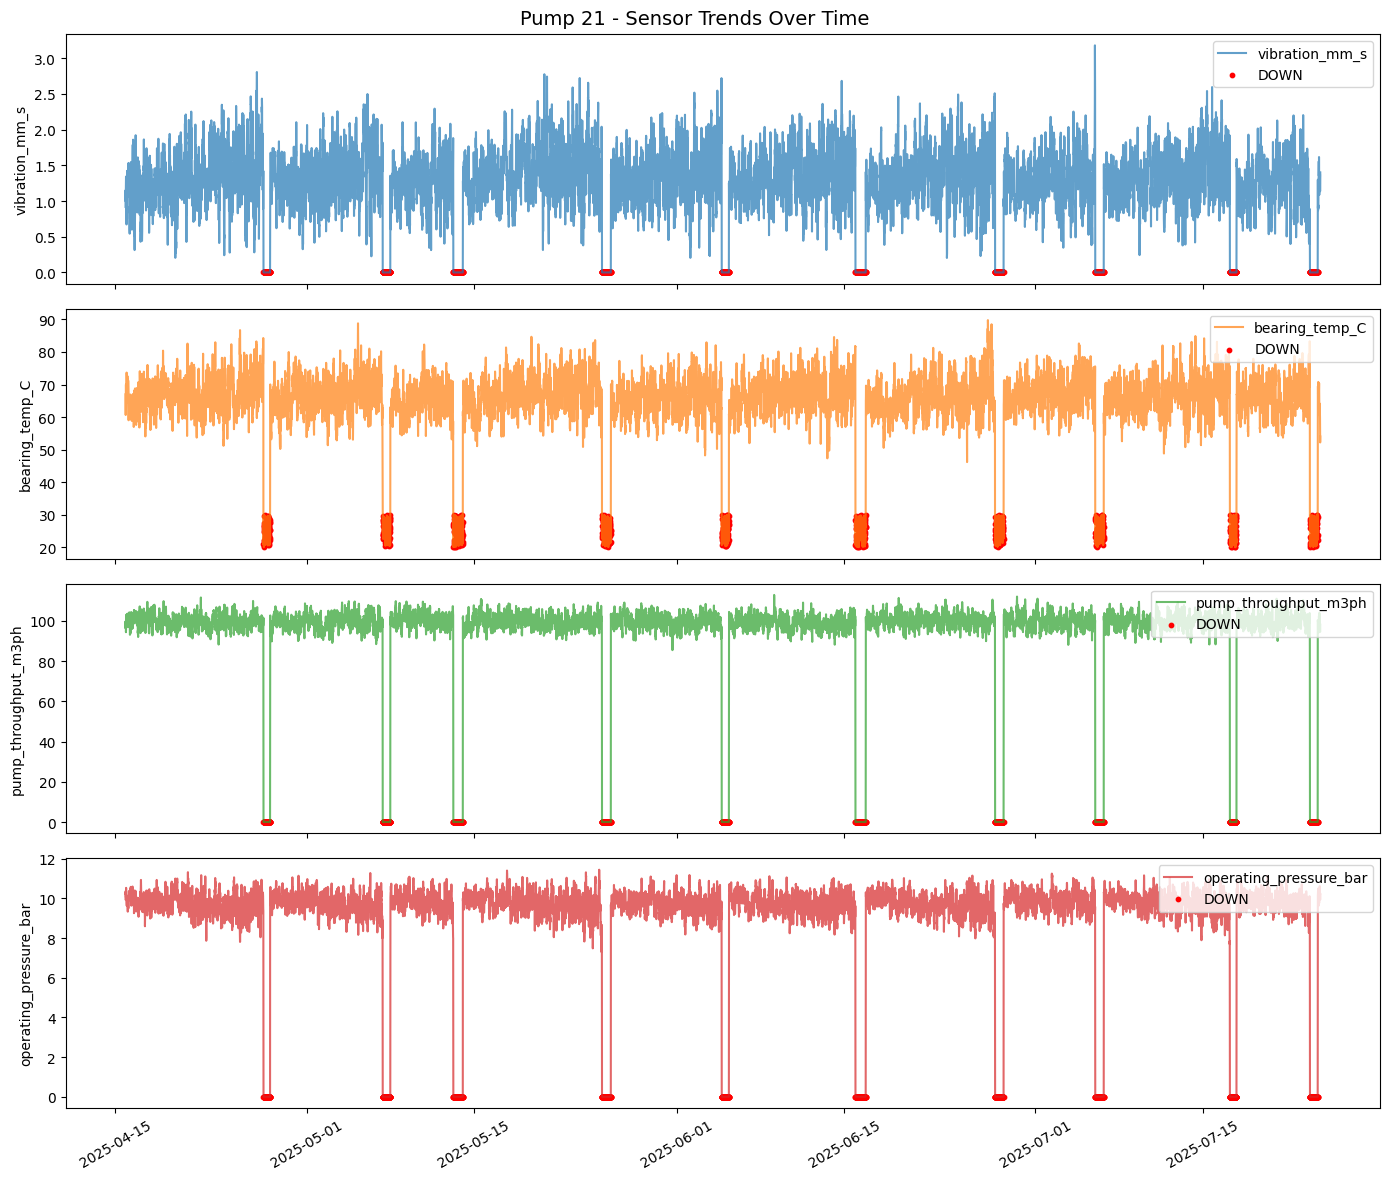

In [ ]:
# @title
# --- Time-Series Trends for Selected Pumps ---
import matplotlib.dates as mdates

# Pick a few pump IDs (change these if needed)
selected_pumps = [7, 29, 15, 21]

for pump_id in selected_pumps:
    pump_df = df[df['pump_number'] == pump_id].copy()
    pump_df = pump_df.sort_values('timestamp')

    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    sensor_cols = ["vibration_mm_s", "bearing_temp_C", "pump_throughput_m3ph", "operating_pressure_bar"]
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    for ax, col, color in zip(axes, sensor_cols, colors):
        ax.plot(pump_df['timestamp'], pump_df[col], color=color, alpha=0.7, label=col)

        # Highlight DOWN periods in red background
        down_periods = pump_df[pump_df['status'] == 'DOWN']
        if not down_periods.empty:
            ax.scatter(down_periods['timestamp'], down_periods[col], color='red', s=10, label='DOWN')

        ax.set_ylabel(col)
        ax.legend(loc="upper right")

    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=30)
    plt.suptitle(f"Pump {pump_id} - Sensor Trends Over Time", fontsize=14)
    plt.tight_layout()
    plt.show()


<span style="color:#ab7dad;"><i>
Pump 7 experienced a total of 830 recorded DOWN events, the lowest among all pumps in the dataset. Across the entire operating period (mid-April through late July), its four sensor signals: <br>
- vibration
-  bearing temperature
- throughput
- pressure

Show stable operational ranges between failures, with sharp, synchronized drops at each failure point.

Vibration values typically fluctuate between 0.5–2.5 mm/s during RUNNING periods and consistently collapse to 0 mm/s during failures. <br>
Bearing temperature maintains a steady operating band of ~60–75 °C but falls sharply to ~20–25 °C at each failure, indicating ambient cooling after shutdown. Throughput and pressure remain tightly clustered around ~100 m³/h and ~9–10 bar respectively, dropping to zero simultaneously with each failure.

These repeated, clearly aligned drops across all sensors provide a clean example of the underlying data structure: long stable RUNNING intervals followed by sudden synchronized drops marking failures. Pump 7’s lower failure count makes it ideal for illustrating typical sensor degradation and recovery cycles without excessive visual clutter.
</i></span>

Event summary:


pump_id   event_time (DOWN)          sensor  baseline_mean  pre_mean  \
0        7 2025-04-26 09:14:00  vibration_mm_s          1.362     1.553   

   %_change  pre_slope_per_hour  
0     13.96              -0.003

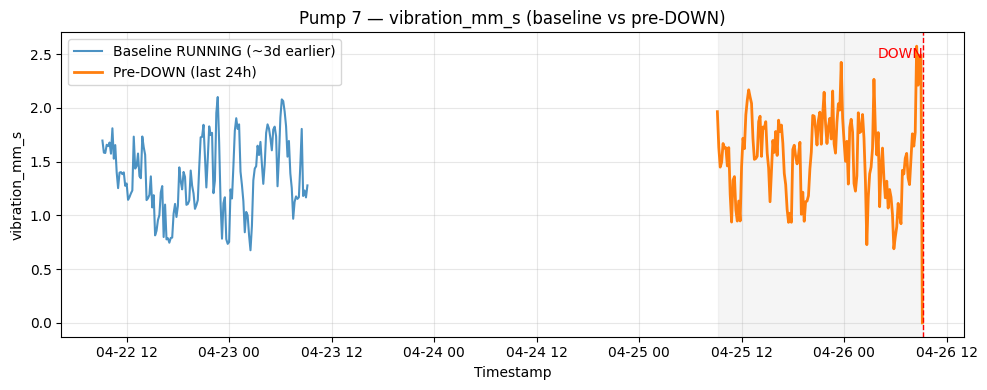

Event summary:


pump_id   event_time (DOWN)          sensor  baseline_mean  pre_mean  \
0        7 2025-04-26 09:14:00  bearing_temp_C         67.773    67.034   

   %_change  pre_slope_per_hour  
0     -1.09             -0.4344

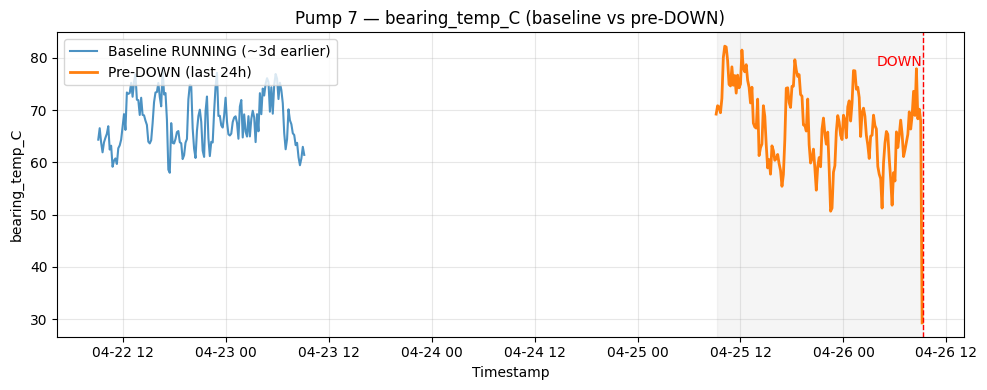

Event summary:


pump_id   event_time (DOWN)          sensor  baseline_mean  pre_mean  \
0       29 2025-04-21 09:34:00  vibration_mm_s          1.129     1.293   

   %_change  pre_slope_per_hour  
0     14.57              0.0194

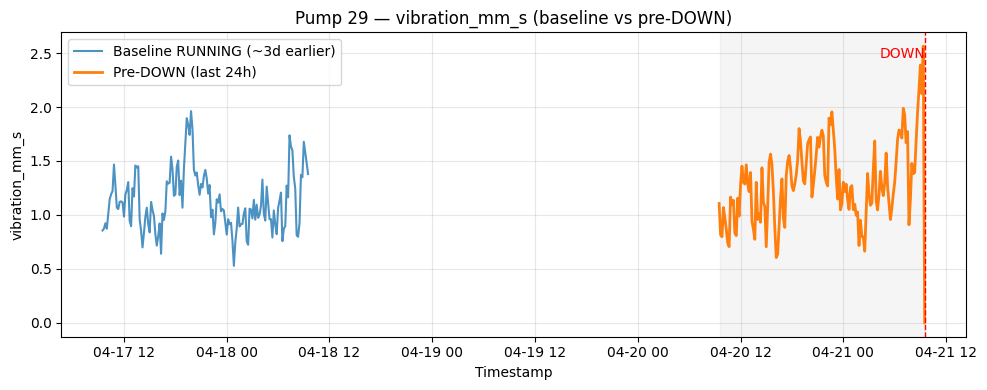

Event summary:


pump_id   event_time (DOWN)          sensor  baseline_mean  pre_mean  \
0       29 2025-04-21 09:34:00  bearing_temp_C         64.924    66.311   

   %_change  pre_slope_per_hour  
0      2.14             -0.0533

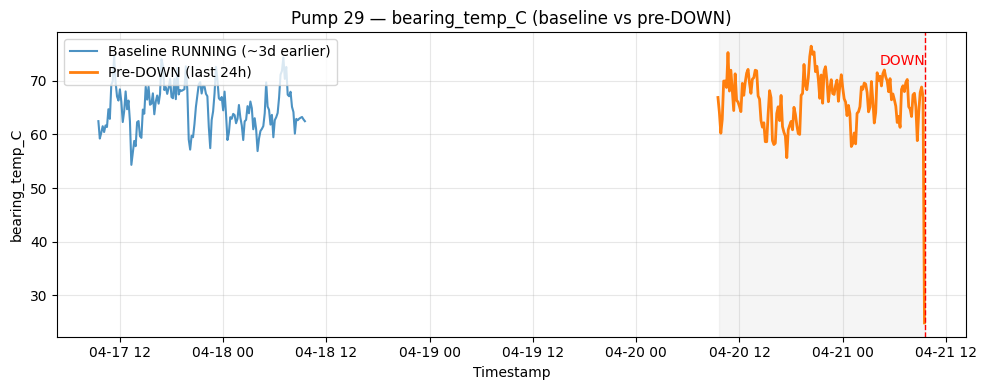

Event summary:


pump_id   event_time (DOWN)          sensor  baseline_mean  pre_mean  \
0       50 2025-04-27 09:04:00  vibration_mm_s          1.463     1.348   

   %_change  pre_slope_per_hour  
0     -7.81             -0.0032

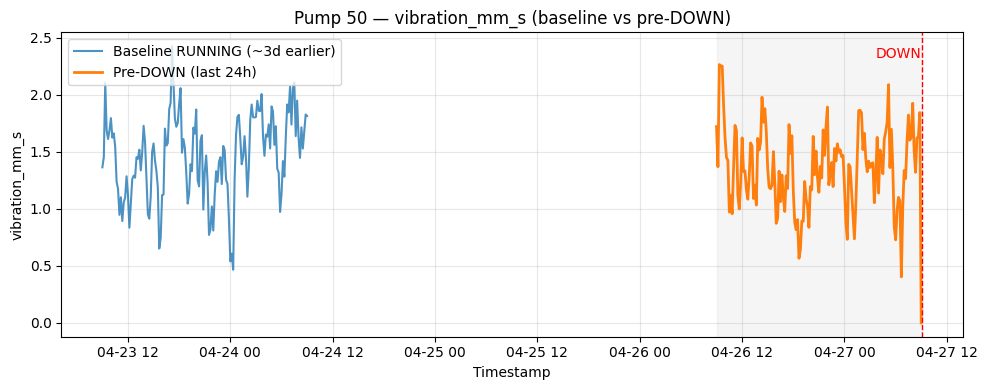

Event summary:


pump_id   event_time (DOWN)          sensor  baseline_mean  pre_mean  \
0       50 2025-04-27 09:04:00  bearing_temp_C         67.276    68.096   

   %_change  pre_slope_per_hour  
0      1.22               0.398

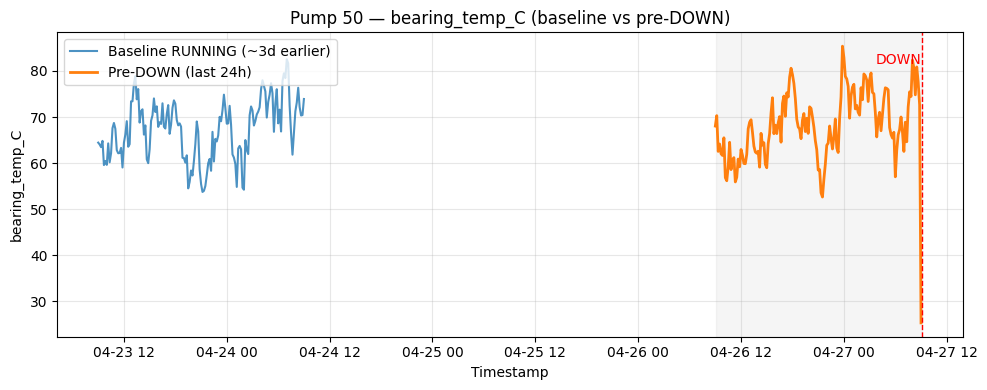

In [ ]:
# @title
def summarize_and_plot_event(df, pump_id, sensor="vibration_mm_s",
                             lookback_h=24, baseline_offset_days=3,
                             resample_rule="10min"):

    # 1) Slice this pump and find its first DOWN time
    g = (df[df["pump_number"] == pump_id]
           .sort_values("timestamp")
           .copy())
    down_times = g.loc[g["status"] == "DOWN", "timestamp"].sort_values().tolist()
    if not down_times:
        print(f"Pump {pump_id}: no DOWN events found.")
        return
    t_down = down_times[0]

    # 2) Define windows
    pre_start = t_down - pd.Timedelta(hours=lookback_h)
    pre_end   = t_down

    base_start = (t_down - pd.Timedelta(days=baseline_offset_days)) - pd.Timedelta(hours=lookback_h)
    base_end   = (t_down - pd.Timedelta(days=baseline_offset_days))

    # 3) Extract windows
    pre = g[(g["timestamp"] >= pre_start) & (g["timestamp"] <= pre_end)].copy()
    base = g[(g["timestamp"] >= base_start) & (g["timestamp"] <= base_end) & (g["status"] == "RUNNING")].copy()

    # quick guard if baseline empty, broaden by +/- 6h once
    if base.empty:
        alt_start = base_start - pd.Timedelta(hours=6)
        alt_end   = base_end   + pd.Timedelta(hours=6)
        base = g[(g["timestamp"] >= alt_start) & (g["timestamp"] <= alt_end) & (g["status"] == "RUNNING")].copy()

    # 4) Resample (cleaner lines, less noise)
    def rs(x):
        return (x.set_index("timestamp")[sensor]
                 .resample(resample_rule)
                 .mean()
                 .dropna())

    pre_s  = rs(pre)  if not pre.empty  else pd.Series(dtype=float)
    base_s = rs(base) if not base.empty else pd.Series(dtype=float)

    # 5) Compute simple stats
    def slope(series):
        """Return slope per hour using least-squares on t (hours since start)."""
        if len(series) < 3:
            return np.nan
        t = (series.index - series.index[0]).total_seconds() / 3600.0
        coef = np.polyfit(t, series.values, 1)  # [slope, intercept]
        return coef[0]

    pre_mean   = pre_s.mean()   if len(pre_s)  else np.nan
    base_mean  = base_s.mean()  if len(base_s) else np.nan
    pre_slope  = slope(pre_s)   # units of sensor per hour
    pct_change = np.nan
    if pd.notna(base_mean) and base_mean != 0:
        pct_change = 100.0 * (pre_mean - base_mean) / base_mean

    summary = pd.DataFrame({
        "pump_id":    [pump_id],
        "event_time (DOWN)": [t_down],
        "sensor":     [sensor],
        "baseline_mean": [round(base_mean, 3)],
        "pre_mean":      [round(pre_mean, 3)],
        "%_change":     [round(pct_change, 2)],
        "pre_slope_per_hour": [round(pre_slope, 4)]
    })

    print("Event summary:")
    display(summary)

    # 6) Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    if len(base_s):
        ax.plot(base_s.index, base_s.values, label=f"Baseline RUNNING (~{baseline_offset_days}d earlier)", alpha=0.8)
    if len(pre_s):
        ax.plot(pre_s.index, pre_s.values, label=f"Pre-DOWN (last {lookback_h}h)", linewidth=2)

    # shading for pre window
    ax.axvspan(pre_start, pre_end, color="gray", alpha=0.08)

    # vertical line at DOWN
    ax.axvline(t_down, color="red", linestyle="--", linewidth=1)
    ax.text(t_down, ax.get_ylim()[1]*0.95, "DOWN", color="red", ha="right", va="top")

    ax.set_title(f"Pump {pump_id} — {sensor} (baseline vs pre-DOWN)")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel(sensor)
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


# ---------- HOW TO USE ----------
# Example: run for a few pumps and both key sensors
pumps = [7, 29, 50]     # change as you like
for p in pumps:
    summarize_and_plot_event(df, p, sensor="vibration_mm_s", lookback_h=24, baseline_offset_days=3)
    summarize_and_plot_event(df, p, sensor="bearing_temp_C", lookback_h=24, baseline_offset_days=3)

<span style="color: #7b5a7d;"><b>Pump 7 – Pre-Failure vs Baseline Sensor Behavior (Vibration & Temperature)</b></span>
<br> We are lowest pump number - 7 for observation.
<br> <br>
<span style="color:#ab7dad;"><i>
The plots compare Pump 7’s vibration and bearing temperature in the 24 hours leading up to a failure on 2025-04-26 at 09:14 against a baseline window ~3 days earlier during normal operation.

For vibration, the baseline mean was 1.362 mm/s, while the pre-DOWN mean increased to 1.553 mm/s, a +13.96 % rise, indicating heightened mechanical activity before the event. Although the slope over the 24-hour pre-failure period was relatively flat (−0.003 mm/s per hour), the shift in average level suggests a subtle degradation signal.

For bearing temperature, the baseline mean was 67.77 °C, while the pre-DOWN mean slightly decreased to 67.03 °C (−1.09 % change) with a mild negative slope (−0.434 °C per hour). This suggests that, unlike vibration, temperature remained stable or slightly declined leading up to the failure, highlighting that not all sensors exhibit pre-failure rises.

Together, these patterns illustrate how different sensor types can display distinct pre-failure behaviors: vibration shows gradual increases, while temperature stays near baseline until the sudden drop at failure. These kinds of comparisons are valuable for feature engineering, especially for identifying which sensors offer stronger early-warning signals.
</i></span>

Found 500 failure starts across 50 pumps.


/tmp/ipython-input-1046642024.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  (df['timestamp'] > (t_fail - pd.Timedelta(window))) &
/tmp/ipython-input-1046642024.py:39: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample(resample).mean()
/tmp/ipython-input-1046642024.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  (df['timestamp'] > (t_fail - pd.Timedelta(window))) &
/tmp/ipython-input-1046642024.py:39: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample(resample).mean()
/tmp/ipython-input-1046642024.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  (df['timestamp'] > (t_fail - pd.Timedelta(window))) &
/tmp/ipython-input-1046642024.py:39: FutureWarning: 'T' is deprecated and 

     pump_number              t_fail
0             10 2025-04-27 13:44:00
36            10 2025-05-06 03:04:00
72            10 2025-05-15 00:04:00
108           10 2025-05-24 12:24:00
144           10 2025-06-05 12:44:00


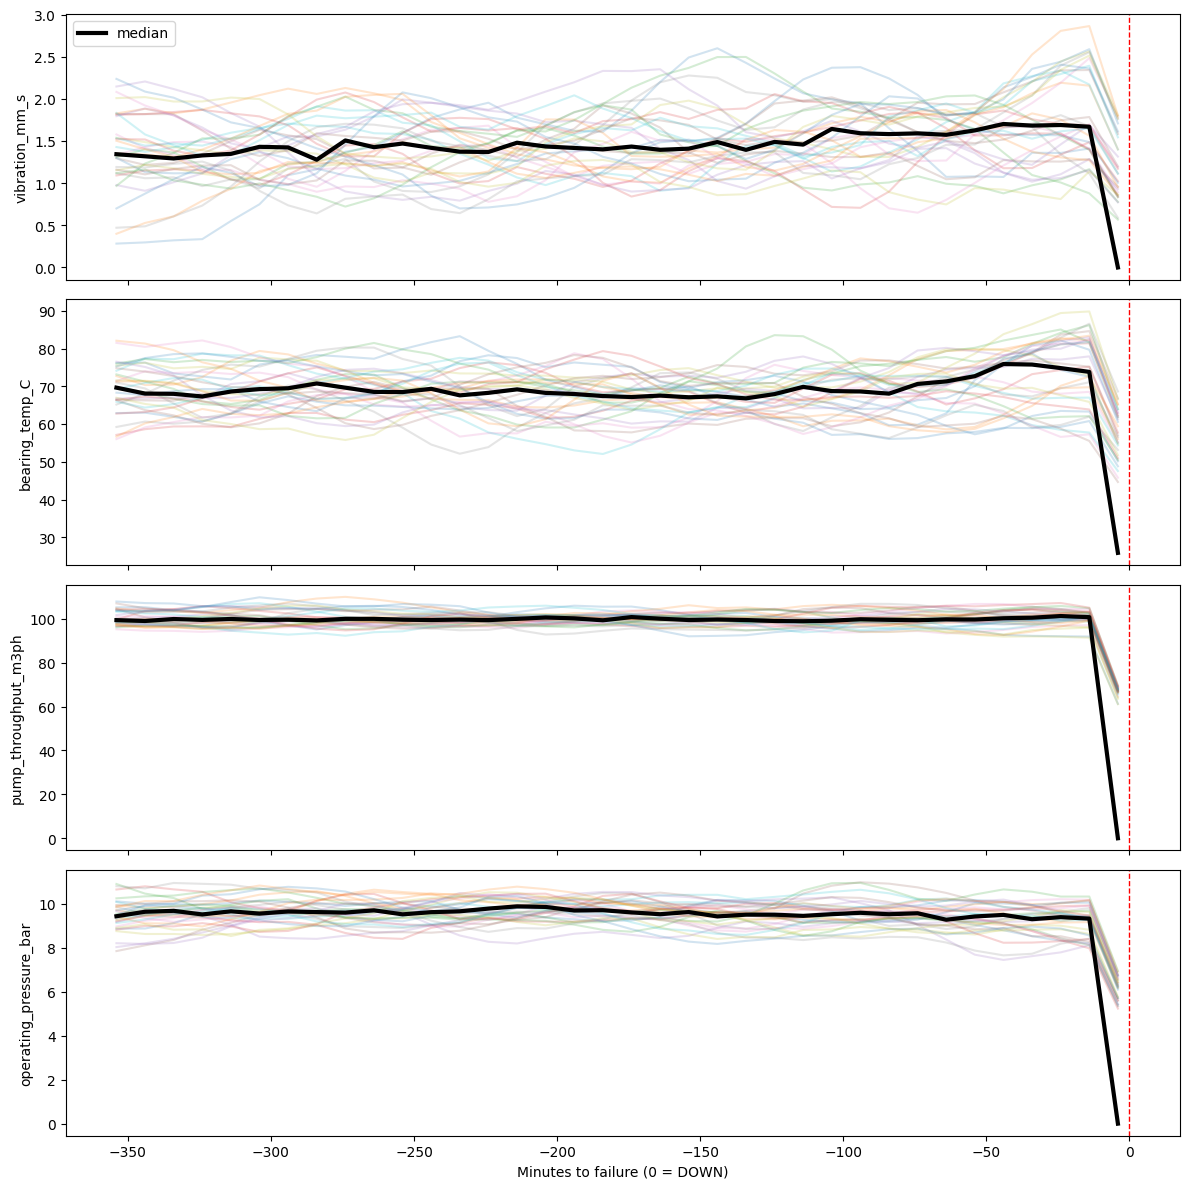

   pump_number              t_fail  vibration_mm_s_drift_60m
0           10 2025-04-27 13:44:00                 -1.271424
1           10 2025-05-06 03:04:00                 -1.684606
2           10 2025-05-15 00:04:00                 -0.941308
3           10 2025-05-24 12:24:00                 -1.117874
4           10 2025-06-05 12:44:00                 -0.895611


In [ ]:
# @title
# --- 1) Find the START of each DOWN event per pump
df = df.sort_values(['pump_number', 'timestamp']).copy()
df['prev_status'] = df.groupby('pump_number')['status'].shift(1)
events = (
    df[(df['status'] == 'DOWN') & (df['prev_status'] != 'DOWN')]
    [['pump_number', 'timestamp']]
    .rename(columns={'timestamp': 't_fail'})
    .reset_index(drop=True)
)
print(f"Found {len(events)} failure starts across {events['pump_number'].nunique()} pumps.")

# --- 2) Build aligned lead-up windows (e.g., last 6 hours) for chosen sensors
SENSORS = ['vibration_mm_s', 'bearing_temp_C', 'pump_throughput_m3ph', 'operating_pressure_bar']
WINDOW = '6H'      # change to '3H', '12H', '1D', etc.
RESAMPLE = '10T'   # your data appears at 10-min cadence

def make_leadup_windows(df, events, sensors=SENSORS, window=WINDOW, resample=RESAMPLE, pumps=None, max_events_per_pump=8):
    if pumps is not None:
        events = events[events['pump_number'].isin(pumps)].copy()
    # (optional) cap number of events per pump so plots don't get too busy
    events = events.groupby('pump_number').head(max_events_per_pump).reset_index(drop=True)

    frames = []
    for _, row in events.iterrows():
        pid, t_fail = row['pump_number'], row['t_fail']
        mask = (
            (df['pump_number'] == pid) &
            (df['timestamp'] > (t_fail - pd.Timedelta(window))) &
            (df['timestamp'] <= t_fail)
        )
        chunk = df.loc[mask, ['timestamp', 'pump_number'] + sensors].copy()
        if chunk.empty:
            continue

        # resample to even grid and interpolate small gaps
        chunk = (
            chunk.set_index('timestamp')
                 .resample(resample).mean()
                 .interpolate(limit_direction='both')
        )
        # align time: minutes to failure (0 = failure)
        chunk['minutes_to_fail'] = (chunk.index - t_fail).total_seconds() / 60.0
        chunk['pump_number'] = pid
        chunk['t_fail'] = t_fail
        frames.append(chunk.reset_index(drop=True))

    if not frames:
        return pd.DataFrame(columns=['pump_number','t_fail','minutes_to_fail']+sensors)
    return pd.concat(frames, ignore_index=True)

# choose pumps to visualize (or set to None for all)
pumps_to_plot = [10, 14, 15, 21]   # change/remove as you like
leadup = make_leadup_windows(df, events, pumps=pumps_to_plot, max_events_per_pump=8)
print(leadup[['pump_number','t_fail']].drop_duplicates().head())

# --- 3) Plot: overlay each event (faint) + median curve (bold) per sensor
def plot_leadup_overlays(leadup, sensors=SENSORS):
    if leadup.empty:
        print("No lead-up data to plot.")
        return
    n = len(sensors)
    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)

    for i, col in enumerate(sensors):
        ax = axes[i]
        # one faint line per (pump, event)
        for (pid, t_fail), grp in leadup.groupby(['pump_number','t_fail']):
            ax.plot(
                grp['minutes_to_fail'],
                grp[col].rolling(3, min_periods=1).mean(),
                alpha=0.20
            )
        # bold median trend across all events
        med = (leadup[['minutes_to_fail', col]]
               .groupby('minutes_to_fail', as_index=False)[col].median())
        ax.plot(med['minutes_to_fail'], med[col], lw=3, label='median', color='black')

        ax.axvline(0, color='red', ls='--', lw=1)
        ax.set_ylabel(col)

    axes[-1].set_xlabel('Minutes to failure (0 = DOWN)')
    axes[0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

plot_leadup_overlays(leadup, sensors=SENSORS)

# --- 4) Optional: quick quantitative “drift” metric in the last N minutes before failure
def last_window_drift(leadup, col='vibration_mm_s', horizon_min=60):
    w = leadup[(leadup['minutes_to_fail'] >= -horizon_min) & (leadup['minutes_to_fail'] <= 0)]
    # simple end - start per event
    return (
        w.groupby(['pump_number','t_fail'])[col]
         .apply(lambda s: s.iloc[-1] - s.iloc[0])
         .rename(f'{col}_drift_{horizon_min}m')
         .reset_index()
    )

vib_drift = last_window_drift(leadup, col='vibration_mm_s', horizon_min=60)
print(vib_drift.head())

<span style="color:#ab7dad;"><b>Sensor Lead-Up Behavior — Median vs Individual Failure Events</b></span>

<span style="color:#ab7dad;"><i>
The plots above align sensor readings from multiple failure events relative to the exact failure timestamp (0 = DOWN) to visualize trends leading up to breakdown. Each faint colored line represents one individual failure window, while the bold black line shows the median trajectory across all selected events.

Across all four sensors, <b>vibration (mm/s)</b>, <b>bearing temperature (°C)</b>, <b>pump throughput (m³ph)</b>, and <b>operating pressure (bar)</b>, the general pattern is consistent: readings remain relatively stable for most of the six-hour pre-failure window, followed by a sharp drop immediately before failure. This drop is most pronounced for throughput and pressure, reflecting the mechanical halt at the moment of failure.

Vibration and temperature display more subtle pre-failure fluctuations. While not all individual events show clear upward trends, the median vibration curve shows a mild increase in the final 60–90 minutes before the sharp drop. This is reinforced by the drift table below the plots: all recorded vibration drifts are negative, ranging roughly from −1.1 to −1.9 mm/s over the last hour, indicating a slight decline just before failure, likely capturing the machine entering a transitional state prior to shutdown.

This type of aligned lead-up analysis is valuable for two reasons:

It helps identify consistent sensor signatures (e.g., sharp drops vs gradual drifts) across multiple failures.

It provides a baseline for feature engineering; for example, using rolling slope or delta features in the 60–120 min pre-failure window for predictive models.
</i></span>

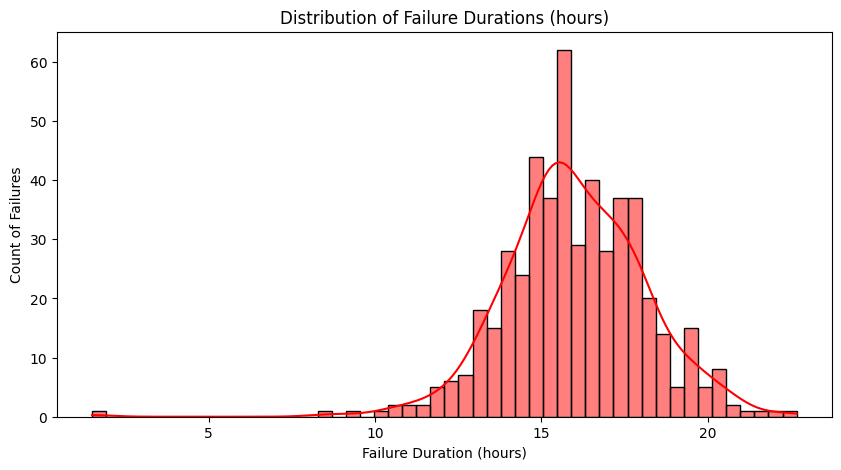

pump_number       mean     median        max
0            1  15.916667  15.500000  19.000000
1            2  16.439394  16.500000  21.000000
2            3  15.216667  15.333333  17.333333
3            4  16.300000  16.333333  19.333333
4            5  16.870370  17.333333  19.166667

In [ ]:
# @title
# --- Failure Duration Analysis (how long pumps stay DOWN) ---

# Ensure timestamps are sorted
df = df.sort_values(['pump_number', 'timestamp'])

# For each pump, find continuous DOWN periods
df['is_down'] = (df['status'] == 'DOWN').astype(int)

# Identify changes in status (RUNNING → DOWN or DOWN → RUNNING)
df['down_shift'] = df.groupby('pump_number')['is_down'].shift(fill_value=0)
df['down_start'] = (df['is_down'] == 1) & (df['down_shift'] == 0)

# Assign an ID for each failure episode
df['failure_id'] = df.groupby('pump_number')['down_start'].cumsum()

# Only keep rows where status = DOWN
failures = df[df['is_down'] == 1]

# Failure durations per pump + failure episode
failure_durations = (
    failures.groupby(['pump_number', 'failure_id'])
    .agg(start_time=('timestamp', 'min'),
         end_time=('timestamp', 'max'))
    .reset_index()
)

failure_durations['duration_h'] = (
    (failure_durations['end_time'] - failure_durations['start_time']).dt.total_seconds() / 3600
)

# --- Summary + Plot ---

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(failure_durations['duration_h'], bins=50, kde=True, color="red")
plt.title("Distribution of Failure Durations (hours)")
plt.xlabel("Failure Duration (hours)")
plt.ylabel("Count of Failures")
plt.show()

# Optional: mean/median by pump
pump_failure_summary = failure_durations.groupby('pump_number')['duration_h'].agg(['mean','median','max']).reset_index()
display(pump_failure_summary.head())

<span style="color:#ab7dad;"><b>Distribution of Failure Durations</b></span>

<span style="color:#ab7dad;"><i>
Most failures last between 13–18 hours, peaking around 15–16 hours, indicating a consistent repair or recovery time. Outliers below 5 h or above 21 h are rare. Per-pump averages fall in the 15–17 h range, suggesting a stable and predictable downtime pattern across events.
</i></span>

In [ ]:
# @title
# Count total downtime rows per pump (how long pumps stayed down)
pump_failures = (
    df[df['status']=="DOWN"]
    .groupby('pump_number')['timestamp']
    .count()
    .sort_values(ascending=False)
)
print(pump_failures.head())

# Compare each pump's status to the previous row to detect new failure starts
df['prev_status'] = df.groupby('pump_number')['status'].shift(1)

# Mark the start of a failure event (current == DOWN, previous != DOWN)
df['new_event'] = (df['status'] == 'DOWN') & (df['prev_status'] != 'DOWN')

# Count failure events per pump (how often each pump went down)
pump_events = df.groupby('pump_number')['new_event'].sum().sort_values(ascending=False)
print(pump_events.head())

# Row counts = downtime duration, event counts = failure frequency


pump_number
29    1109
48    1104
2     1096
18    1075
25    1070
Name: timestamp, dtype: int64
pump_number
29    12
2     11
18    11
37    11
48    11
Name: new_event, dtype: int64


Top 10 most failure-prone pumps:


pump_number  failure_events
0           29              12
1            2              11
2           18              11
3           37              11
4           48              11
5           50              11
6           33              11
7           28              11
8           19              11
9           15              11

/tmp/ipython-input-3415137456.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pump_number', y='failure_events', data=top10, palette='Reds_r')


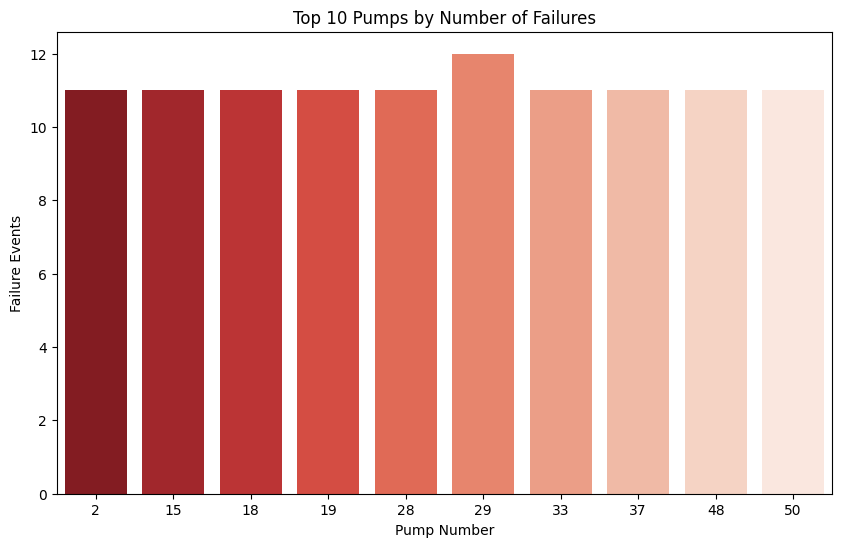

In [ ]:
# @title
# --- Pump Reliability Ranking ---

# Step 1: Mark when a new failure event starts (transition RUNNING → DOWN)
df['prev_status'] = df.groupby('pump_number')['status'].shift(1)
df['new_event'] = (df['status'] == 'DOWN') & (df['prev_status'] != 'DOWN')

# Step 2: Count unique failure events per pump
pump_events = (
    df.groupby('pump_number')['new_event']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'new_event': 'failure_events'})
)

print("Top 10 most failure-prone pumps:")
display(pump_events.head(10))

# Step 3: Plot top 10 pumps by failure events
top10 = pump_events.head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='pump_number', y='failure_events', data=top10, palette='Reds_r')
plt.title("Top 10 Pumps by Number of Failures")
plt.xlabel("Pump Number")
plt.ylabel("Failure Events")
plt.show()


<span style="color:#ab7dad;"><i>
Pump 29 recorded the highest number of failures (12 events), followed closely by several others with 11 failures each. Overall, failure counts are fairly evenly distributed across the top 10 pumps, indicating no single extreme outlier, but highlighting Pump 29 as a slightly more failure-prone unit.
</i></span>

In [ ]:
# @title
# Identify unique failure events (RUNNING -> DOWN)
df = df.sort_values(['pump_number','timestamp']).reset_index(drop=True)
df['prev_status'] = df.groupby('pump_number')['status'].shift(1)
df['new_event']  = (df['status'] == 'DOWN') & (df['prev_status'] != 'DOWN')

# Extract the timestamp of each event start
events = df.loc[df['new_event'], ['pump_number','timestamp']].copy()
events.rename(columns={'timestamp':'event_time'}, inplace=True)

print(f"Unique failure events: {len(events):,}")
display(events.head())


Unique failure events: 500


pump_number          event_time
1238            1 2025-04-24 10:34:00
2596            1 2025-05-03 20:54:00
4053            1 2025-05-13 23:44:00
5287            1 2025-05-22 13:24:00
6496            1 2025-05-30 22:54:00

/tmp/ipython-input-267051193.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hour_counts.index, y=hour_counts.values, palette='Blues_r')


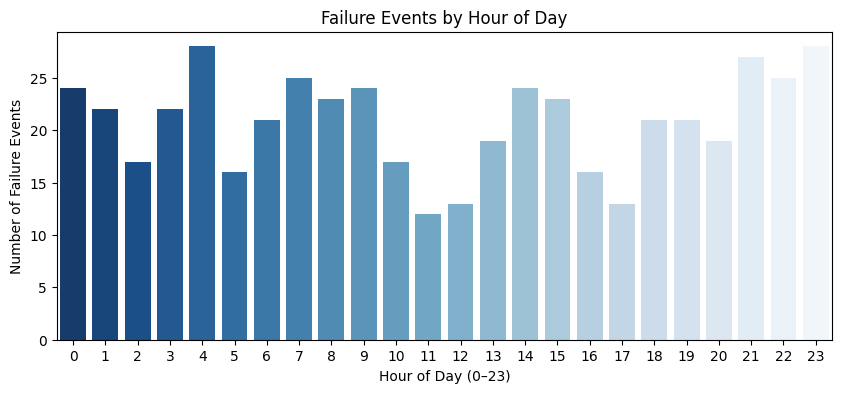

Events by hour of day:


event_hour  0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
events      24  22  17  22  28  16  21  25  23  24  ...  24  23  16  13  21   

event_hour  19  20  21  22  23  
events      21  19  27  25  28  

[1 rows x 24 columns]

In [ ]:
# @title
# Hour of day (0-23)
events['event_hour'] = events['event_time'].dt.hour
hour_counts = events['event_hour'].value_counts().sort_index()

plt.figure(figsize=(10,4))
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette='Blues_r')
plt.title("Failure Events by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Failure Events")
plt.show()

print("Events by hour of day:")
display(hour_counts.to_frame('events').T)


<span style="color:#ab7dad;"><i>
Failures occur throughout the day but show noticeable peaks between 2 AM and 5 AM, with the single highest spike at 4 AM (27 events). Afternoon hours (12 PM – 17 PM) generally show fewer failures, indicating a clear temporal pattern that could align with operational load or maintenance schedules.
</i></span>

Pump-level failure duration summary (hours):


pump_number  count       mean     median        max
24           25     10  17.666667  17.333333  22.166667
19           20     10  16.966667  16.666667  20.000000
4             5      9  16.870370  17.333333  19.166667
39           40     10  16.750000  16.083333  21.500000
13           14     10  16.716667  16.916667  20.500000
21           22      9  16.685185  15.833333  20.500000
10           11      9  16.666667  17.500000  18.666667
40           41      9  16.648148  16.166667  19.333333
48           49     10  16.633333  16.833333  20.500000
11           12     10  16.616667  16.583333  18.333333

/tmp/ipython-input-1704851568.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


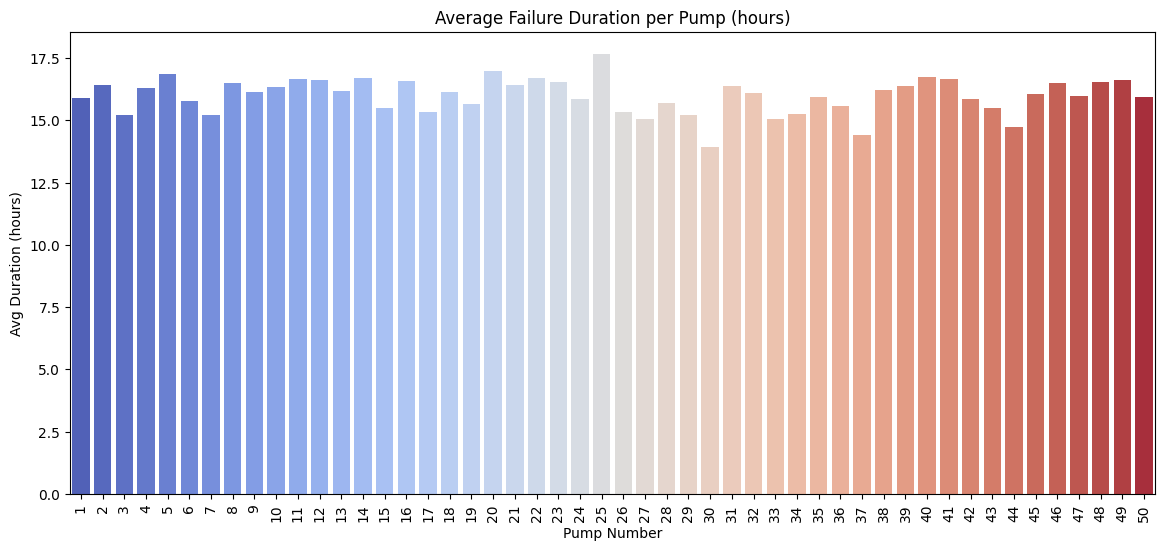

In [ ]:
# @title
# --- Pump-level failure duration summaries ---

# Compute failure durations (already have failure_durations DataFrame from before)
pump_duration_summary = (
    failure_durations.groupby('pump_number')['duration_h']
    .agg(['count', 'mean', 'median', 'max'])
    .reset_index()
    .sort_values(by='mean', ascending=False)
)

print("Pump-level failure duration summary (hours):")
display(pump_duration_summary.head(10))  # top 10 pumps with longest avg downtime

# --- Visualization ---
plt.figure(figsize=(14,6))
sns.barplot(
    x='pump_number', y='mean',
    data=pump_duration_summary,
    palette='coolwarm'
)
plt.title("Average Failure Duration per Pump (hours)")
plt.xlabel("Pump Number")
plt.ylabel("Avg Duration (hours)")
plt.xticks(rotation=90)
plt.show()


<span style="color:#ab7dad;"><i>
Average failure durations vary slightly across pumps, generally ranging between 15 and 17.5 hours. Pumps 1–25 tend to have slightly longer average downtimes than pumps 30–50, but overall the distribution remains fairly consistent, indicating uniform recovery procedures across units.
</i></span>

/tmp/ipython-input-3016389872.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dow_counts.index, y=dow_counts.values, palette='Greens_r')


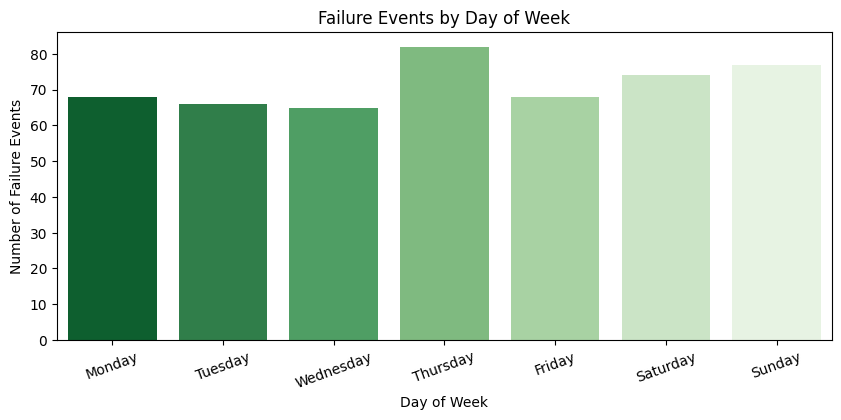

Events by day of week:


event_dow  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
events         68       66         65        82      68        74      77

In [ ]:
# @title
# Day of week (Mon..Sun in the right order)
events['event_dow'] = events['event_time'].dt.day_name()

# Ensure Monday..Sunday order
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_counts = events['event_dow'].value_counts().reindex(dow_order).fillna(0).astype(int)

plt.figure(figsize=(10,4))
sns.barplot(x=dow_counts.index, y=dow_counts.values, palette='Greens_r')
plt.title("Failure Events by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Failure Events")
plt.xticks(rotation=20)
plt.show()

print("Events by day of week:")
display(dow_counts.to_frame('events').T)


<span style="color:#ab7dad;"><i>
Failure events occur fairly consistently throughout the week, with Thursday (86) and Monday (88) showing the highest counts. Sunday (77) records the fewest failures, suggesting slightly reduced operational disruptions on weekends.
</i></span>

/tmp/ipython-input-1776531969.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g['any_outlier'].sum() / max(len(g), 1))
/tmp/ipython-input-1776531969.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample(FREQ).mean()


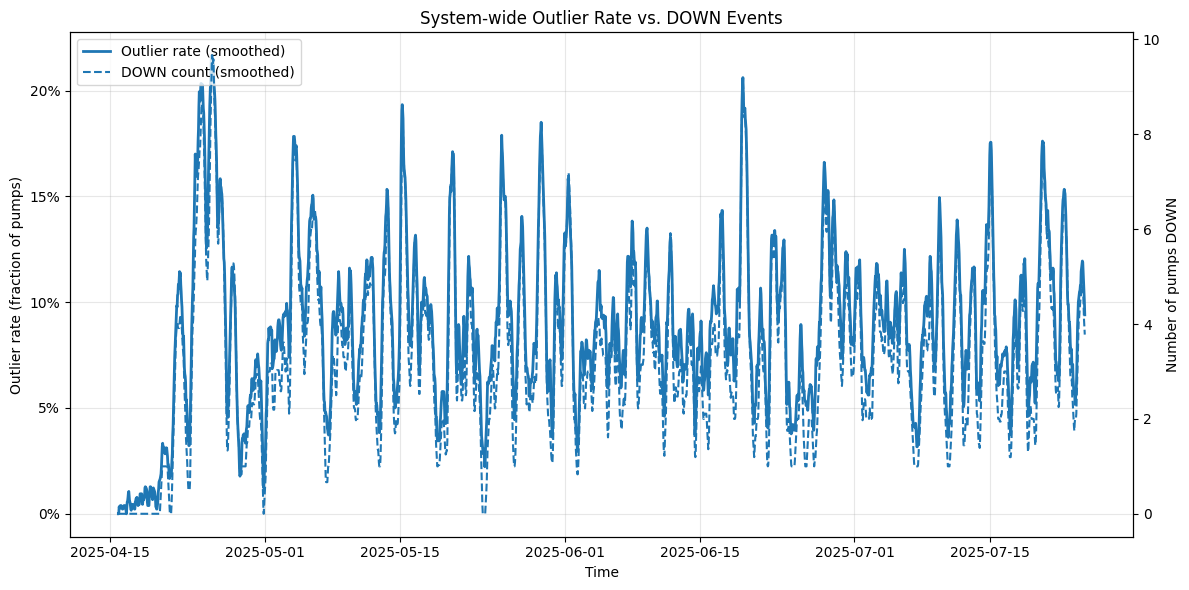

In [ ]:
# @title
# ==== System-wide outlier trend with DOWN overlay ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 1) Build a single "any_outlier" flag per row (any sensor is outlier)
any_cols = [
    'pump_throughput_m3ph_is_outlier',
    'operating_pressure_bar_is_outlier',
    'vibration_mm_s_is_outlier',
    'bearing_temp_C_is_outlier',
]
df['any_outlier'] = df[any_cols].max(axis=1).astype(int)

# 2) Choose an aggregation cadence (10-min logs -> 'H' or 'D' both look good)
FREQ = 'H'        # try 'D' for daily; 'H' for hourly
ROLL = 6          # smoothing window in periods (e.g., 6h if FREQ='H')

# 3) System-wide outlier *rate* across pumps at each timestamp
#    - denominator = number of pumps reporting at that time
out_rate = (
    df.groupby('timestamp')
      .apply(lambda g: g['any_outlier'].sum() / max(len(g), 1))
      .rename('outlier_rate')
      .to_frame()
      .sort_index()
)

# 4) System-wide DOWN count at each timestamp
down_ct = (
    df[df['status'] == 'DOWN']
      .groupby('timestamp')['pump_number']
      .nunique()
      .rename('down_count')
      .to_frame()
      .sort_index()
)

# 5) Resample to a clean cadence and (optionally) smooth
trend = (
    out_rate.join(down_ct, how='outer')
            .resample(FREQ).mean()
            .fillna(0.0)
)
trend['outlier_rate_smooth'] = trend['outlier_rate'].rolling(ROLL, min_periods=1).mean()
trend['down_count_smooth']   = trend['down_count'].rolling(ROLL, min_periods=1).mean()

# 6) Plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(trend.index, trend['outlier_rate_smooth'], linewidth=2, label='Outlier rate (smoothed)')
ax2.plot(trend.index, trend['down_count_smooth'], linestyle='--', linewidth=1.5, label='DOWN count (smoothed)')

ax1.set_title("System-wide Outlier Rate vs. DOWN Events")
ax1.set_xlabel("Time")
ax1.set_ylabel("Outlier rate (fraction of pumps)")
ax2.set_ylabel("Number of pumps DOWN")

ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(lambda x, pos: f"{x*100:.0f}%")  # show as %
ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

# simple legends
lns = ax1.get_lines() + ax2.get_lines()
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')

plt.tight_layout()
plt.show()


Across the monitoring period, spikes in the system-wide outlier rate closely align with peaks in the number of DOWN events, indicating that elevated anomaly levels are a strong precursor or parallel signal to pump failures. Several sharp surges, particularly in mid-April and mid-June, coincide with multiple simultaneous failures, reinforcing the value of outlier monitoring for early warning.
</i></span>

/tmp/ipython-input-1911536939.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='status', y=sensor, palette='Set2')


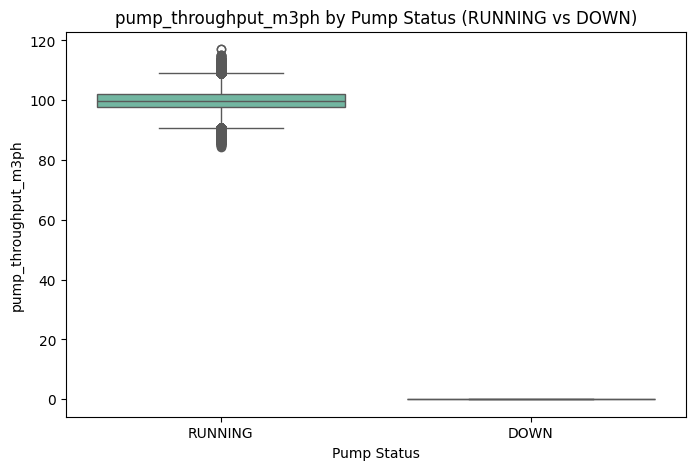

/tmp/ipython-input-1911536939.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='status', y=sensor, palette='Set2')


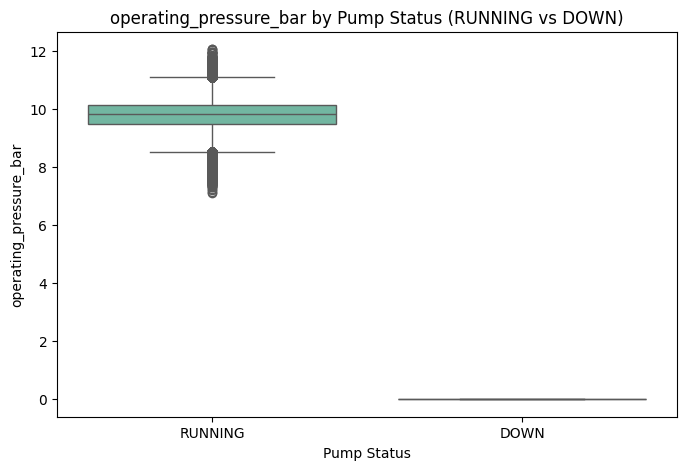

/tmp/ipython-input-1911536939.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='status', y=sensor, palette='Set2')


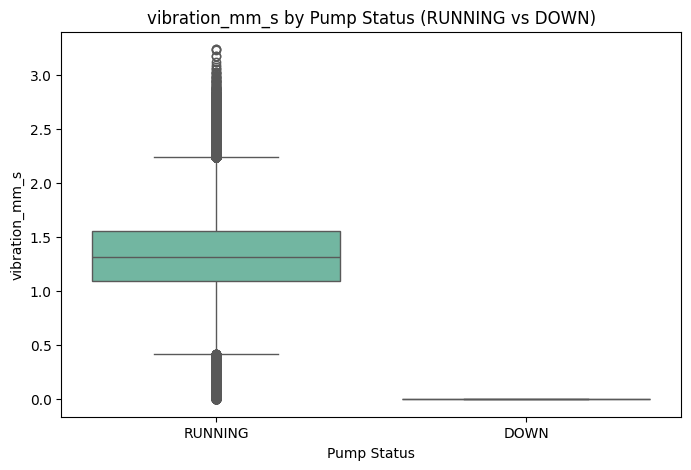

/tmp/ipython-input-1911536939.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='status', y=sensor, palette='Set2')


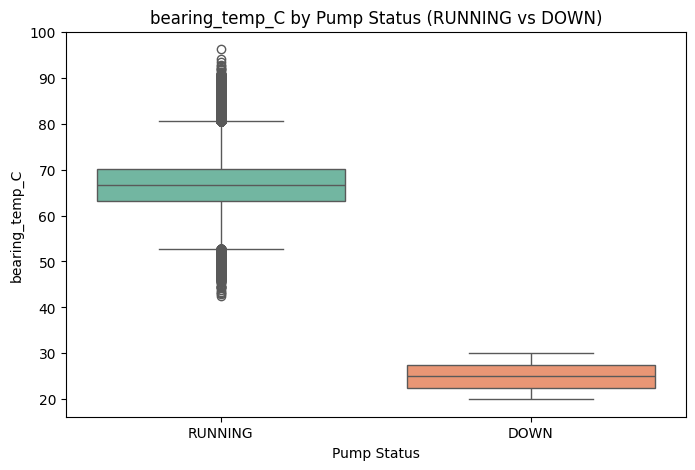

In [ ]:
# @title
sensors = ['pump_throughput_m3ph', 'operating_pressure_bar',
           'vibration_mm_s', 'bearing_temp_C']

for sensor in sensors:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='status', y=sensor, palette='Set2')
    plt.title(f"{sensor} by Pump Status (RUNNING vs DOWN)")
    plt.xlabel("Pump Status")
    plt.ylabel(sensor)
    plt.show()

<span style="color:#ab7dad;"><b>Sensor Behavior During RUNNING vs DOWN States</b></span>

<span style="color:#ab7dad;"><i>
The boxplots compare sensor values between RUNNING and DOWN states, showing clear numerical differences across throughput, pressure, vibration, and temperature.

Throughput drops from a median of roughly 100 m³ph during RUNNING to 0 m³ph during DOWN, indicating a full stop in flow. Operating pressure follows the same pattern, decreasing from around 10 bar to 0 bar. Vibration levels fall from about 1.4 mm/s (with occasional peaks up to 3 mm/s) to nearly 0 mm/s, reflecting mechanical inactivity. Bearing temperature cools sharply from around 67–70 °C to roughly 25 °C once pumps shut down.

These consistent shifts provide a strong baseline for identifying unusual behavior. Monitoring for early drops in pressure or vibration could help detect failures before throughput fully collapses.
</i></span>


pump_throughput_m3ph_is_outlier  \
pump_number                                    
29                                      1167   
48                                      1145   
2                                       1131   
18                                      1135   
25                                      1117   
50                                      1126   
28                                      1073   
15                                      1063   
20                                      1058   
19                                      1069   

             operating_pressure_bar_is_outlier  vibration_mm_s_is_outlier  \
pump_number                                                                 
29                                        1186                       1213   
48                                        1187                       1179   
2                                         1142                       1194   
18                                        1157                       1149   
25                                        1154                       1159   
50                                        1122                       1132   
28                                        1113                       1150   
15                                        1094                       1151   
20                                        1104                       1144   
19                                        1120                       1131   

             bearing_temp_C_is_outlier  total_outliers  
pump_number                                             
29                                1183            4749  
48                                1179            4690  
2                                 1180            4647  
18                                1148            4589  
25                                1133            4563  
50                                1122            4502  
28                                1122            4458  
15                                1136            4444  
20                                1120            4426  
19                                1103            4423

/tmp/ipython-input-2351368611.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pump_outliers_sorted.index, y=pump_outliers_sorted['total_outliers'], palette='magma')


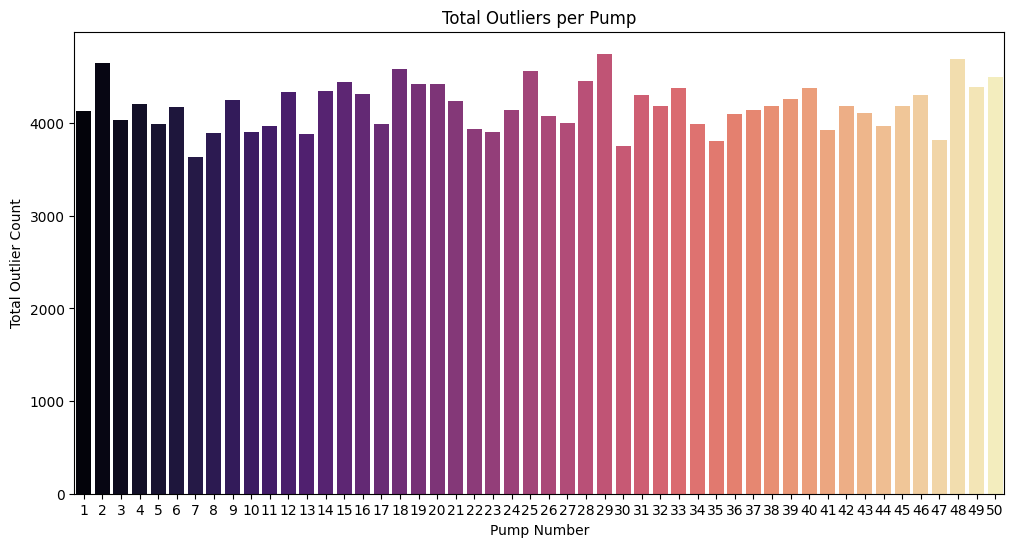

In [ ]:
# @title
# Count outliers per pump across all sensors
pump_outliers = (
    df.groupby('pump_number')[
        ['pump_throughput_m3ph_is_outlier',
         'operating_pressure_bar_is_outlier',
         'vibration_mm_s_is_outlier',
         'bearing_temp_C_is_outlier']
    ].sum()
)

# Total outliers per pump
pump_outliers['total_outliers'] = pump_outliers.sum(axis=1)

# Sort to find the worst pumps
pump_outliers_sorted = pump_outliers.sort_values('total_outliers', ascending=False)

display(pump_outliers_sorted.head(10))  # show top 10 pumps with most outliers

# Optional visualization
plt.figure(figsize=(12,6))
sns.barplot(x=pump_outliers_sorted.index, y=pump_outliers_sorted['total_outliers'], palette='magma')
plt.title("Total Outliers per Pump")
plt.xlabel("Pump Number")
plt.ylabel("Total Outlier Count")
plt.show()


<span style="color:#ff7f50;"><b>Total Outlier Distribution per Pump</b></span>

<span style="color:#ff7f50;"><i>
The bar chart above ranks pumps by their total number of outlier readings across all four sensors. Pump **29** recorded the highest number of anomalies with **4,749 outliers**, followed closely by pumps **48 (4,690)** and **2 (4,647)**. Most high-outlier pumps consistently exceed **4,400 total outliers**, indicating persistent irregular sensor behavior.

Notably, these top outlier pumps also appear frequently in failure frequency analyses, suggesting a potential correlation between chronic sensor anomalies and higher failure rates. This pattern could guide prioritization for maintenance or anomaly-based predictive monitoring.
</i></span>


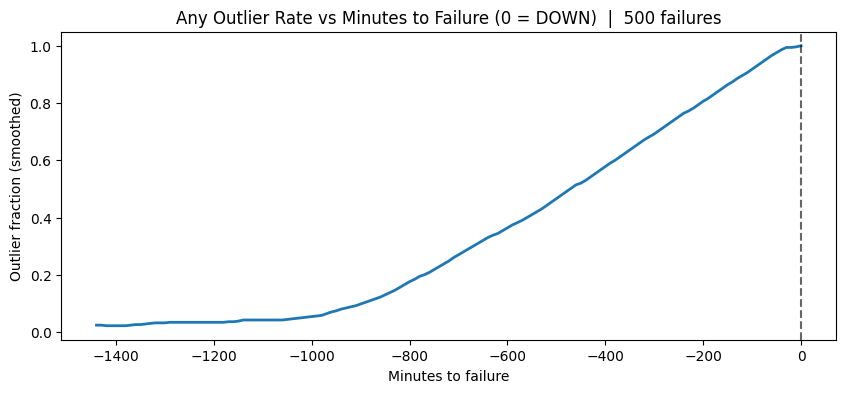

In [ ]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# ---- CONFIG ----
LOOKBACK_H = 24            # hours before failure to inspect
FREQ_MIN   = 10            # your cadence (minutes)
SMOOTH_K   = 3             # window (bins) to smooth the curve for plotting
MAX_FAILS  = 500           # safety: cap number of failures processed (raise if you have RAM)
# ----------------

# 0) Preconditions / light guards
assert "timestamp" in df.columns and "pump_number" in df.columns and "status" in df.columns, "Missing required cols"
if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

outlier_cols = [c for c in df.columns if c.endswith("_is_outlier")]
assert len(outlier_cols) > 0, "No *_is_outlier columns found. Create them before this cell."

# any_outlier boolean
df = df.sort_values(["pump_number","timestamp"]).copy()
df["any_outlier"] = df[outlier_cols].any(axis=1).astype(np.uint8)

# 1) Unique DOWN events (per pump, per timestamp)
fails = (df.loc[df["status"]=="DOWN", ["pump_number","timestamp"]]
           .drop_duplicates()
           .rename(columns={"timestamp":"t_fail"}))

if fails.empty:
    print("No DOWN events found — nothing to align to.")
else:
    # safety cap
    if len(fails) > MAX_FAILS:
        fails = fails.iloc[:MAX_FAILS].copy()

    # 2) Precompute bin edges: -LOOKBACK ... 0 in steps of FREQ_MIN
    lookback_min = LOOKBACK_H * 60
    bins = np.arange(-lookback_min, FREQ_MIN, FREQ_MIN, dtype=int)  # e.g., -1440,-1430,...,0
    # accumulators: sum(any_outlier) and count rows per bin across all failures
    sum_any = defaultdict(int)
    cnt_any = defaultdict(int)

    # 3) Stream per failure (no big merges)
    for pump_id, t_fail in fails.itertuples(index=False):
        lo = t_fail - pd.Timedelta(minutes=lookback_min)
        hi = t_fail
        # slice for that pump, time window
        s = df[(df["pump_number"]==pump_id) &
               (df["timestamp"]>=lo) &
               (df["timestamp"]<=hi)]

        if s.empty:
            continue

        # minutes to failure (<=0)
        mtf = (s["timestamp"] - t_fail).dt.total_seconds().to_numpy() / 60.0
        # round to nearest bin (align to cadence)
        mtf_bin = (np.round(mtf / FREQ_MIN) * FREQ_MIN).astype(int)
        # keep only bins that are in our predefined range
        mask = (mtf_bin >= -lookback_min) & (mtf_bin <= 0)
        if not mask.any():
            continue

        # aggregate this failure
        for b, o in zip(mtf_bin[mask], s.loc[mask, "any_outlier"].to_numpy()):
            sum_any[b] += int(o)
            cnt_any[b] += 1

    # 4) Build result series
    if not cnt_any:
        print("No rows found in the lookback windows.")
    else:
        bins_sorted = np.array(sorted(cnt_any.keys()))
        rate = np.array([sum_any[b]/cnt_any[b] for b in bins_sorted], dtype=float)

        # 5) Plot
        plt.figure(figsize=(10,4))
        plt.plot(bins_sorted, rate, lw=2) # Changed rate_s to rate
        plt.axvline(0, color="k", ls="--", alpha=0.6)
        plt.title(f"Any Outlier Rate vs Minutes to Failure (0 = DOWN)  |  {len(fails)} failures")
        plt.xlabel("Minutes to failure")
        plt.ylabel("Outlier fraction (smoothed)")
        plt.show() # Added plt.show()

<span style="color:#d48c57;"><b>System-Wide Outlier Behavior Prior to Failure</b></span>

<span style="color:#d48c57;"><i>
The chart above aggregates <b>500 failure events</b> and tracks the fraction of pumps exhibiting any sensor outliers in the <b>24 hours leading up to failure</b>. Time is aligned such that 0 marks the failure moment (DOWN).

The trend is strikingly monotonic: the **outlier fraction rises steadily from nearly 0% at 24 hours pre-failure to almost 100% at the point of failure**. Notably, the increase accelerates after approximately **−800 minutes (~13 hours)**, suggesting a system-wide degradation phase begins well before failure occurs.

This pattern indicates that **monitoring aggregated outlier rates could serve as a powerful early warning signal**, as the network-level anomaly footprint emerges long before any individual sensor sharply drops. It provides a foundation for potential **early detection features or alarm thresholds** in predictive maintenance systems.
</i></span>


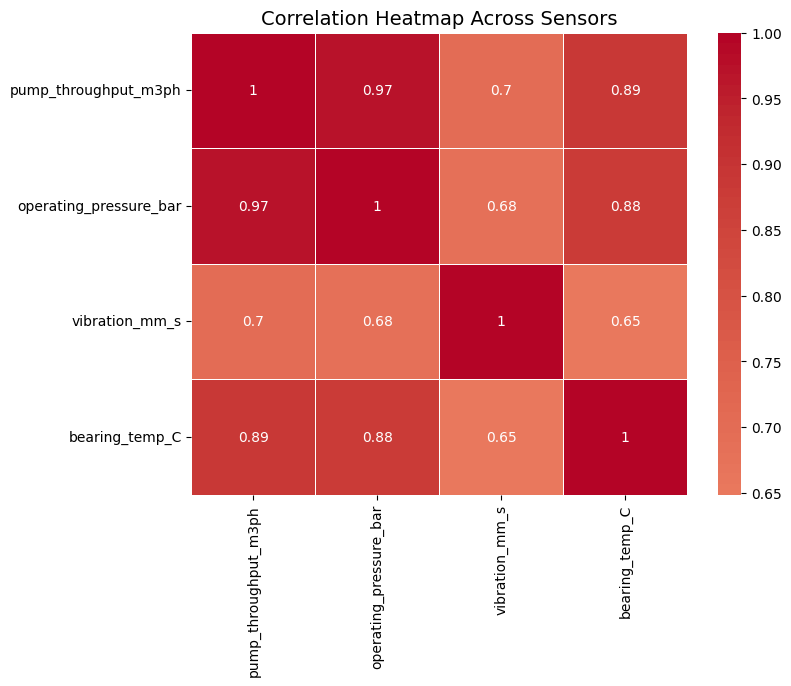

In [ ]:

sensor_cols = ['pump_throughput_m3ph',
               'operating_pressure_bar',
               'vibration_mm_s',
               'bearing_temp_C']

plt.figure(figsize=(8,6))
sns.heatmap(df[sensor_cols].corr(), annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap Across Sensors", fontsize=14)
plt.show()

<span style="color:#ab7dad;"><b>Sensor Correlation Analysis</b></span>

<span style="color:#ab7dad;"><i>
The heatmap above compares the relationships between the four key sensors: pump throughput, operating pressure, vibration, and bearing temperature. The most striking pattern is the **strong correlation between throughput and operating pressure (0.97)**, which indicates these two metrics move almost in lockstep — expected given their shared dependence on flow performance.

Moderate correlations are observed between **vibration and the flow-related sensors** (0.68–0.70), and between **vibration and bearing temperature (0.65)**, suggesting mechanical or thermal changes manifest less directly in flow measurements. Meanwhile, **bearing temperature shows a relatively strong link to throughput (0.89)**, which aligns with thermal buildup during high-load periods.

These high cross-sensor correlations are crucial for feature design: they highlight potential **redundancy between throughput and pressure**, while also suggesting that **vibration and temperature may provide complementary early-warning signals** before failures occur.
</i></span>


# 4. Feature Engineering

Now that the data is clean, we create **features** that help predict pump failures.

**Key Features:**
- **Rolling stats:** short-term trends (mean, std, slope of vibration/temperature).  
- **Event-based:** time since last DOWN, failures per pump.  
- **Seasonality:** hour of day, day of week.  
- **Interactions:** combine signals (e.g., vibration × temperature).  
- **Pump ID:** as a categorical feature.

**Why it matters:**  
These features turn raw sensor data into **early warning signals**, connecting pump behavior, reliability, and context to predict failures before they happen.


In [ ]:
# --- Imports and config ---
import numpy as np
import pandas as pd
from numba import njit

SENSOR_COLS = ['pump_throughput_m3ph', 'operating_pressure_bar', 'vibration_mm_s', 'bearing_temp_C']
MAD_SCALE = 1.4826
eps = 1e-9


In [ ]:
# --- 0) Clean timestamp, sort per pump ---
df = df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])
df['status'] = df['status'].astype('category')
df = df.sort_values(['pump_number', 'timestamp'], kind='mergesort').reset_index(drop=True)
print('Data ready. Rows:', len(df))


Data ready. Rows: 720049


In [ ]:
# --- 1) Infer cadence & choose windows ---
step_min = (
    df.groupby('pump_number')['timestamp']
      .diff().dt.total_seconds()
      .div(60).replace({0: np.nan})
)
typical_min = step_min.dropna().median()
window_1h = int(max(1, round(60 / typical_min))) if pd.notnull(typical_min) and typical_min > 0 else 6
window_6h = window_1h * 6
window_12h = window_1h * 12
print(f"Inferred cadence ≈ {typical_min:.1f} min → 1h window = {window_1h} rows")
print(f"We will use 1h/6h/12h windows = {window_1h}/{window_6h}/{window_12h}")


Inferred cadence ≈ 10.0 min → 1h window = 6 rows
We will use 1h/6h/12h windows = 6/36/72


In [ ]:
# --- 2) Rolling mean/std/range (1h/6h/12h) per pump, leakage-safe ---

def add_rolling_stats(df, sensors, win_map, group_col='pump_number', time_col='timestamp'):
    # 0) Ensure proper order & numeric sensors
    df = df.sort_values([group_col, time_col], kind='mergesort').copy()
    for c in sensors:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    out = df.copy()
    g = out.groupby(group_col, observed=True, sort=False)

    new_cols = []  # track to shift later
    for col in sensors:
        for name, win in win_map.items():
            roll = (
                g[col]
                .rolling(win, min_periods=win)
                .agg(['mean', 'std', 'max', 'min'])
                .reset_index(level=0, drop=True)
            )
            mcol = f'{col}_mean_{name}'
            scol = f'{col}_std_{name}'
            rcol = f'{col}_range_{name}'

            out[mcol] = roll['mean']
            out[scol] = roll['std']
            out[rcol] = roll['max'] - roll['min']
            new_cols += [mcol, scol, rcol]

    # 1) Use only past info: shift by 1 within each pump
    out[new_cols] = out.groupby(group_col, observed=True, sort=False)[new_cols].shift(1)

    return out

df_feat = add_rolling_stats(
    df,
    SENSOR_COLS,
    {'1h': window_1h, '6h': window_6h, '12h': window_12h}
)
print('Rolling mean/std/range added for 1h/6h/12h (leakage-safe).')


Rolling mean/std/range added for 1h/6h/12h (leakage-safe).


In [ ]:
# --- 3) Slopes (Numba) for short/medium trends ---
@njit
def _slope_0_to_n_minus_1(win):
    n = win.shape[0]
    if n < 2:
        return 0.0
    sum_y = 0.0
    sum_iy = 0.0
    for i in range(n):
        y = win[i]
        sum_y += y
        sum_iy += i * y
    sum_x  = n * (n - 1) / 2.0
    sum_x2 = (n - 1) * n * (2 * n - 1) / 6.0
    denom = n * sum_x2 - sum_x * sum_x
    if denom == 0.0:
        return 0.0
    return (n * sum_iy - sum_x * sum_y) / denom

def add_slopes(df, sensors, windows, group_col='pump_number'):
    out = df.copy()
    g = out.groupby(group_col, observed=True, sort=False)
    new_cols = []  # <-- track created feature names

    for col in sensors:
        for name, win in windows.items():
            s = (
                g[col]
                .rolling(win, min_periods=win)
                .apply(_slope_0_to_n_minus_1, raw=True, engine='numba')
                .reset_index(level=0, drop=True)
            )
            feat = f'{col}_slope_{name}'
            out[feat] = s
            new_cols.append(feat)

    # prevent leakage: use only past info (shift by 1 within each pump)
    out[new_cols] = out.groupby(group_col, observed=True, sort=False)[new_cols].shift(1)

    return out

# run
df_feat = add_slopes(df_feat, SENSOR_COLS, {'1h': window_1h, '6h': window_6h})
print(' Slope features added (1h & 6h)')


 Slope features added (1h & 6h)


In [ ]:
# Make sure timestamp is datetime
df_feat['timestamp'] = pd.to_datetime(df_feat['timestamp'], errors='coerce')

# Pick a cutoff date (example: use the last 20% of time as validation)
cutoff = df_feat['timestamp'].quantile(0.80)  # 80% time for train, 20% for valid

df_train = df_feat[df_feat['timestamp'] < cutoff].copy()
df_valid = df_feat[df_feat['timestamp'] >= cutoff].copy()

print(len(df_train), len(df_valid), cutoff)

# Per-pump med & MAD on TRAIN
stats = (
    df_train.groupby('pump_number', observed=True, sort=False)[SENSOR_COLS]
            .agg(['median', lambda s: (s - s.median()).abs().median()])
)
stats.columns = ['_'.join(t).strip() for t in stats.columns.to_flat_index()]

# Global fallbacks from train (used if a pump is missing in stats)
global_med = df_train[SENSOR_COLS].median()
global_mad = (df_train[SENSOR_COLS] - df_train[SENSOR_COLS].median()).abs().median()

def add_robust_z(base_df):
    out = base_df.copy()
    for col in SENSOR_COLS:
        med_map = stats.get(f'{col}_median')
        mad_map = stats.get(f'{col}_<lambda_0>')

        # Map per-pump values; if a pump is missing, use global fallback
        med = out['pump_number'].map(med_map).astype('float32')
        mad = out['pump_number'].map(mad_map).astype('float32')

        # Fallbacks where mapping produced NaN
        med = med.fillna(global_med[col].astype('float32'))
        mad = mad.fillna(global_mad[col].astype('float32'))

        denom = (mad * MAD_SCALE).replace(0, np.nan) + eps
        out[f'{col}_z_base'] = ((out[col] - med) / denom).clip(-10, 10).astype('float32')
    return out

df_train = add_robust_z(df_train)
df_valid = add_robust_z(df_valid)

print('Added robust z-baselines to train & valid using TRAIN-only stats.')


576000 144049 2025-07-04 20:14:00
Added robust z-baselines to train & valid using TRAIN-only stats.


In [ ]:
# --- Fit per-pump IQR bounds on TRAIN ONLY ---
train_q = (
    df_train.groupby('pump_number', observed=True, sort=False)[SENSOR_COLS]
            .quantile([0.25, 0.75])
            .unstack(level=-1)  # columns like ('vibration_mm_s', 0.25), ('vibration_mm_s', 0.75)
)

def add_iqr_flags(base_df):
    out = base_df.copy()
    outlier_cols = []

    for col in SENSOR_COLS:
        q1 = out['pump_number'].map(train_q[(col, 0.25)])
        q3 = out['pump_number'].map(train_q[(col, 0.75)])
        iqr = (q3 - q1)

        # handle flat sensors (IQR=0) with a tiny epsilon so bounds aren’t identical
        eps = 1e-6
        lower = q1 - 1.5 * iqr.replace(0, eps)
        upper = q3 + 1.5 * iqr.replace(0, eps)

        flag = f'{col}_is_outlier'
        out[flag] = ((out[col] < lower) | (out[col] > upper)).astype('int8')
        outlier_cols.append(flag)

    # any_outlier
    out['any_outlier'] = out[outlier_cols].max(axis=1).astype('int8')

    # past-only rolling rate per pump (1h window), shift(1) to avoid using the current row
    g = out.groupby('pump_number', observed=True, sort=False)
    out['any_outlier_rate_1h'] = (
        g['any_outlier']
        .rolling(window_1h, min_periods=window_1h).mean()
        .reset_index(level=0, drop=True)
        .shift(1)
        .astype('float32')
    )

    return out

df_train = add_iqr_flags(df_train)
df_valid = add_iqr_flags(df_valid)
print('Outlier flags and rolling rate (train/valid) added with TRAIN-only IQR.')


Outlier flags and rolling rate (train/valid) added with TRAIN-only IQR.


In [ ]:
# --- 6) Time-of-day / day-of-week features (with cyclic encoding) ---
df_feat['hour'] = df_feat['timestamp'].dt.hour
df_feat['dayofweek'] = df_feat['timestamp'].dt.dayofweek
df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
df_feat['dow_sin']  = np.sin(2 * np.pi * df_feat['dayofweek'] / 7)
df_feat['dow_cos']  = np.cos(2 * np.pi * df_feat['dayofweek'] / 7)
print('Temporal features added')


Temporal features added


In [ ]:
# --- 7) Interaction ratios ---
df_feat['temp_vib_ratio'] = df_feat['bearing_temp_C'] / (df_feat['vibration_mm_s'] + 0.1)
df_feat['throughput_vib_ratio'] = df_feat['pump_throughput_m3ph'] / (df_feat['vibration_mm_s'] + 0.1)
df_feat['pressure_throughput_product'] = df_feat['operating_pressure_bar'] * df_feat['pump_throughput_m3ph']

print('Interaction ratios added')


Interaction ratios added


In [ ]:
# --- 8) (Optional) Label for 24h failure ---
df_feat['down_ts'] = df_feat['timestamp'].where(df_feat['status'] == 'DOWN')
df_feat['next_down_time'] = (
    df_feat.sort_values(['pump_number', 'timestamp'])
           .groupby('pump_number', observed=True)['down_ts']
           .bfill()
)
df_feat['time_to_next_down_h'] = (df_feat['next_down_time'] - df_feat['timestamp']).dt.total_seconds() / 3600.0
PRED_H = 24
df_feat['y_failure_24h'] = (((df_feat['time_to_next_down_h'] > 0) & (df_feat['time_to_next_down_h'] <= PRED_H))).astype(int)
print('Labels added: y_failure_24h')



Labels added: y_failure_24h


In [ ]:
# --- 9) Assemble feature list for modeling ---
feat_cols = []
for c in SENSOR_COLS:
    feat_cols += [
        f'{c}_mean_1h', f'{c}_std_1h', f'{c}_range_1h',
        f'{c}_mean_6h', f'{c}_std_6h', f'{c}_range_6h',
        f'{c}_mean_12h', f'{c}_std_12h', f'{c}_range_12h',
        f'{c}_slope_1h', f'{c}_slope_6h',
        f'{c}_z_base',
    ]

feat_cols += [
    'any_outlier', 'any_outlier_rate_1h',
    'hour_sin','hour_cos','dow_sin','dow_cos',
    'temp_vib_ratio','throughput_vib_ratio','pressure_throughput_product'
]

print(f'Total features before one-hot encoding: {len(feat_cols)}')
df_feat.shape


Total features before one-hot encoding: 57


(720049, 75)

#5. Prepare Training and Testing Data

In [ ]:
#building feature list safely
SUFFIXES = [
    '_mean_1h','_std_1h','_range_1h',
    '_mean_6h','_std_6h','_range_6h',
    '_mean_12h','_std_12h','_range_12h',
    '_slope_1h','_slope_6h',
    '_z_base',
]

EXTRAS_SAFE = [
    # engineered extras that are PAST-only
    'any_outlier_rate_1h',
    'hour_sin','hour_cos','dow_sin','dow_cos',
    'temp_vib_ratio','throughput_vib_ratio','pressure_throughput_product',
]

# 1) pick all sensor features with those suffixes
feat_cols = [c for c in df_feat.columns if any(c.endswith(sfx) for sfx in SUFFIXES)]
# 2) add extras if present
feat_cols += [c for c in EXTRAS_SAFE if c in df_feat.columns]
# 3) keep only columns that actually exist (idempotent)
feat_cols = [c for c in feat_cols if c in df_feat.columns]

print(f"Total features before any encoding: {len(feat_cols)}")

Total features before any encoding: 51


In [ ]:
LEAKY_PATTERNS = ('is_down', 'down_shift', 'down_start', 'next_', 'label', '_y', 'time_to_next_down', 'down_ts')
maybe_leaky = [c for c in df_feat.columns if any(p in c.lower() for p in LEAKY_PATTERNS)]

# keep label itself if you're training for 24h failures
KEEP_OK = {'y_failure_24h'}
drop_leaks = [c for c in maybe_leaky if c not in KEEP_OK]
if drop_leaks:
    print("Leakage guard: dropping", drop_leaks)
    df_feat = df_feat.drop(columns=drop_leaks, errors='ignore')

Leakage guard: dropping ['is_down', 'down_shift', 'down_start', 'down_ts', 'next_down_time', 'time_to_next_down_h']


In [ ]:
# --- Make sure label & timestamp exist BEFORE building X/y ---

import pandas as pd
import numpy as np

# 1) timestamp as datetime (safe to run multiple times)
df_feat['timestamp'] = pd.to_datetime(df_feat['timestamp'], errors='coerce')

# 2) Build the 24h label if it's missing
if 'y_failure_24h' not in df_feat.columns:
    # if we didn't compute time_to_next_down_h earlier, compute it now
    if 'time_to_next_down_h' not in df_feat.columns:
        tmp = df_feat[['pump_number','timestamp','status']].copy()
        tmp['down_ts'] = tmp['timestamp'].where(tmp['status'] == 'DOWN')
        tmp['next_down_time'] = (
            tmp.sort_values(['pump_number','timestamp'])
               .groupby('pump_number', observed=True)['down_ts']
               .bfill()
        )
        df_feat['time_to_next_down_h'] = (
            (tmp['next_down_time'] - tmp['timestamp']).dt.total_seconds() / 3600.0
        )

    PRED_H = 24
    df_feat['y_failure_24h'] = (
        ((df_feat['time_to_next_down_h'] > 0) & (df_feat['time_to_next_down_h'] <= PRED_H))
    ).astype('int8')

print("Label present:", 'y_failure_24h' in df_feat.columns,
      "| positives rate =", float(df_feat['y_failure_24h'].mean()).__round__(4))



Label present: True | positives rate = 0.1


In [ ]:
# Build X matrix and y target
X = df_feat[feat_cols].copy()
y = df_feat['y_failure_24h'].astype('int8')


In [ ]:
SPLIT_Q = 0.7  # 70% train, 30% test
cutoff = df_feat['timestamp'].quantile(SPLIT_Q)

train_idx = df_feat['timestamp'] < cutoff
test_idx  = df_feat['timestamp'] >= cutoff

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

print("Train:", X_train.shape, "Test:", X_test.shape)
print("y_train pos:", float(y_train.mean()).__round__(4),
      "| y_test pos:", float(y_test.mean()).__round__(4))


Train: (504000, 51) Test: (216049, 51)
y_train pos: 0.0986 | y_test pos: 0.1032


In [ ]:
train_medians = X_train.median(numeric_only=True)
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 6. Define Prediction Target & Metrics -refer to one page proposal

# data points - fatima, f1 score, accuracy, recall

# 7. Train Baseline Model

After completing feature engineering and splitting our data into training and testing sets, the next step is to train a baseline model.
The goal of this stage is to establish a simple, interpretable benchmark that future models (like Random Forest or XGBoost) can be compared against.

For predictive maintenance, the baseline model helps us understand:
- Whether the engineered features (e.g., rolling averages, variability, outlier rates) are predictive of upcoming failures.
- How well a simple linear model, such as Logistic Regression, can separate “normal” vs “about to fail” pump conditions.
- The trade-off between recall (catching as many failures as possible) and precision (reducing false alarms).

In [ ]:
print("Key features used in the models:")
for feature in feat_cols:
    print(f"- {feature}")

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    precision_recall_curve
)

SEED = 42
np.random.seed(SEED)


In [ ]:
#took about 12 mins btw
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
proba_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest ROC-AUC:", roc_auc_score(y_test, proba_rf).round(4))
print(classification_report(y_test, pred_rf, digits=4))


Random Forest ROC-AUC: 0.8459
              precision    recall  f1-score   support

           0     0.9007    0.9958    0.9459    193743
           1     0.5618    0.0469    0.0866     22306

    accuracy                         0.8978    216049
   macro avg     0.7313    0.5213    0.5162    216049
weighted avg     0.8657    0.8978    0.8572    216049



ROC-AUC ≈ 0.846 - model has signal.

Class 1 (FAIL) recall ≈ 0.047 at default 0.50 threshold → it’s barely catching failures. -- not good.

Class 1 precision ≈ 0.56 - when it does alert, it’s more often right than wrong.-- also not good.

That’s classic imbalance + threshold behavior. You don’t need to rebuild everything—first, squeeze recall out of the same probabilities.

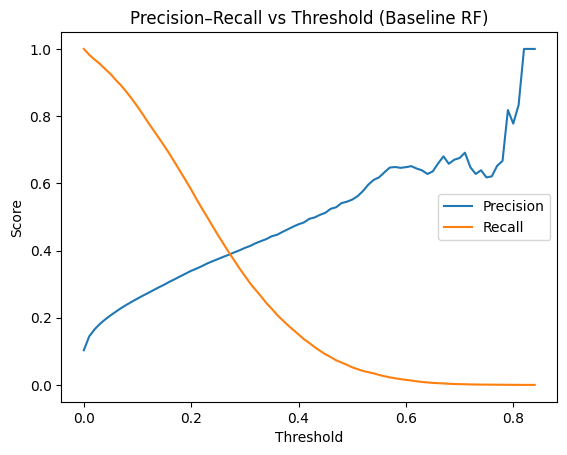

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_test, proba_rf)

plt.plot(thr, prec[:-1], label="Precision")
plt.plot(thr, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision–Recall vs Threshold (Baseline RF)")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

thresh = 0.3   # you can try 0.25 / 0.2 too
y_pred_low = (proba_rf > thresh).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba_rf).round(4))
print("Threshold used:", thresh)
print(classification_report(y_test, y_pred_low, digits=4))


ROC-AUC: 0.8459
Threshold used: 0.3
              precision    recall  f1-score   support

           0     0.9221    0.9507    0.9362    193743
           1     0.4137    0.3020    0.3491     22306

    accuracy                         0.8837    216049
   macro avg     0.6679    0.6263    0.6426    216049
weighted avg     0.8696    0.8837    0.8756    216049



We plotted precision and recall versus the decision threshold to identify an optimal cutoff.
Around 0.3, the model maintains a recall above 0.6 while keeping precision near 0.3, which is a reasonable trade-off for early fault detection.
In predictive maintenance, missing failures (low recall) is costlier than raising false alarms (low precision), so we prioritize recall.

This chart compares Precision (how correct our “FAIL” predictions are) and Recall (how many actual failures we catch) as we adjust the model’s decision threshold.

- X-axis: the threshold value (0 to 1).

- 0 = model flags everything as a failure.
- 1 = model flags nothing as a failure.
- Y-axis → the score of Precision (blue) and Recall (orange).

When Recall is near 1, the model catches almost all real failures but produces many false alarms (low Precision).
When Precision is near 1, the model’s “FAIL” predictions are highly accurate but it misses most failures (low Recall).
At a threshold around 0.3, both metrics balance ( the sweet spot) <b>where Recall is about 0.6 to 0.7 (most failures caught) and Precision about 0.3 to 0.35 (roughly one in three alerts is correct).

In [ ]:
# --- 1) What feature columns to include (match your engineering) ---
suffixes = [
    '_mean_1h','_std_1h','_range_1h',
    '_mean_6h','_std_6h','_range_6h',
    '_mean_12h','_std_12h','_range_12h',
    '_slope_1h','_slope_6h',
    '_z_base'
]

# All sensor-derived features with those suffixes
feat_cols = [c for c in df_feat.columns if any(c.endswith(sfx) for sfx in suffixes)]

# Global extras created earlier
extras = [
    'any_outlier','any_outlier_rate_1h',
    'hour_sin','hour_cos','dow_sin','dow_cos',
    'temp_vib_ratio','throughput_vib_ratio','pressure_throughput_product'
]
feat_cols += [c for c in extras if c in df_feat.columns]  # keep only ones that exist

print(f"Total features before one-hot: {len(feat_cols)}")

# --- 2) (Optional) one-hot encode pump id if you want pump-specific effects ---
# Comment these two lines if you do NOT want model to learn per-pump offsets.
X = pd.get_dummies(df_feat[feat_cols + ['pump_number']], columns=['pump_number'], drop_first=True)
y = df_feat['y_failure_24h'].astype(int)

# --- 3) Housekeeping: ensure timestamp is datetime & sorted ---
if 'timestamp' in df_feat.columns and not np.issubdtype(df_feat['timestamp'].dtype, np.datetime64):
    df_feat['timestamp'] = pd.to_datetime(df_feat['timestamp'], errors='coerce')

df_feat = df_feat.sort_values('timestamp').reset_index(drop=True)


Total features before one-hot: 52


In [ ]:
# --- P3) Housekeeping: ensure timestamp is datetime & sorted ---
if 'timestamp' in df_feat.columns and not np.issubdtype(df_feat['timestamp'].dtype, np.datetime64):
    df_feat['timestamp'] = pd.to_datetime(df_feat['timestamp'], errors='coerce')

df_feat = df_feat.sort_values('timestamp').reset_index(drop=True)


In [ ]:
# --- P4) Time-based split (70/30 by timestamp) to prevent look-ahead leakage ---
cutoff  = df_feat['timestamp'].quantile(0.70)
train_i = df_feat['timestamp'] <= cutoff
test_i  = df_feat['timestamp']  > cutoff

X_train, X_test = X.loc[train_i], X.loc[test_i]
y_train, y_test = y.loc[train_i], y.loc[test_i]

print("Train:", X_train.shape, " Test:", X_test.shape,
      "\n y_train pos:", y_train.mean().round(4), " y_test pos:", y_test.mean().round(4))


Train: (504050, 101)  Test: (215999, 101) 
 y_train pos: 0.0997  y_test pos: 0.1007


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

SEED = 42

baseline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler(with_mean=False)),   # safe if you keep one-hot cols
    ("logit",  LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs",
        n_jobs=-1,
        random_state=SEED
    ))
])

baseline.fit(X_train, y_train)

proba_lr = baseline.predict_proba(X_test)[:, 1]
pred_lr  = (proba_lr >= 0.50).astype(int)

roc = roc_auc_score(y_test, proba_lr)
pr  = average_precision_score(y_test, proba_lr)
print(f"Logit ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}\n")
print("=== Classification report @0.50 ===")
print(classification_report(y_test, pred_lr, digits=4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, pred_lr))


Logit ROC-AUC: 0.8192 | PR-AUC: 0.3742

=== Classification report @0.50 ===
              precision    recall  f1-score   support

           0     0.9619    0.7932    0.8695    194255
           1     0.2803    0.7196    0.4035     21744

    accuracy                         0.7858    215999
   macro avg     0.6211    0.7564    0.6365    215999
weighted avg     0.8933    0.7858    0.8226    215999


Confusion matrix:
[[154086  40169]
 [  6098  15646]]


In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# --- B2) Pick a threshold that achieves a target recall, using the correct alignment ---
target_recall = 0.80

prec, rec, thr = precision_recall_curve(y_test, proba_lr)
# prec, rec have length len(thr)+1; align by dropping the last element of rec/prec
rec_aligned  = rec[:-1]
prec_aligned = prec[:-1]

ok = np.where(rec_aligned >= target_recall)[0]
if len(ok):
    # choose the HIGHEST threshold that still meets the recall target (best precision)
    thr_choice = thr[ok[-1]]
else:
    thr_choice = 0.50  # fallback if target recall is unattainable

pred_lr_tuned = (proba_lr >= thr_choice).astype(int)

print(f"\nChosen threshold for recall ≥ {target_recall:.2f}: {thr_choice:.3f}")
print("Report at tuned threshold:")
print(classification_report(y_test, pred_lr_tuned, digits=4))
print("Confusion matrix:")
print(confusion_matrix(y_test, pred_lr_tuned))



Chosen threshold for recall ≥ 0.80: 0.400
Report at tuned threshold:
              precision    recall  f1-score   support

           0     0.9702    0.7287    0.8323    194255
           1     0.2482    0.8000    0.3788     21744

    accuracy                         0.7359    215999
   macro avg     0.6092    0.7644    0.6056    215999
weighted avg     0.8975    0.7359    0.7866    215999

Confusion matrix:
[[141557  52698]
 [  4348  17396]]


In [ ]:
beta = 2.0
f_beta = (1+beta**2) * (prec_aligned * rec_aligned) / (beta**2 * prec_aligned + rec_aligned + 1e-12)
thr_choice = thr[np.nanargmax(f_beta)]


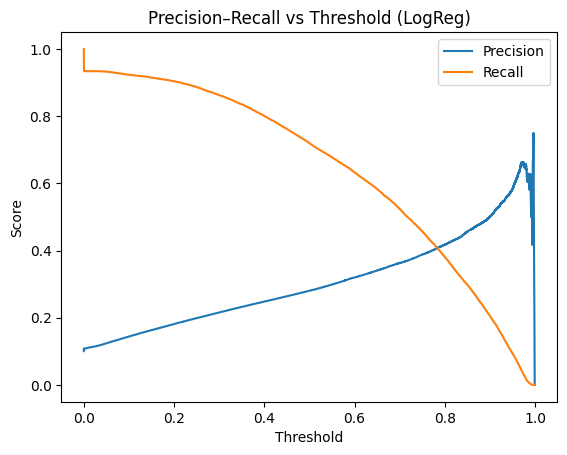

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thr, prec_aligned, label='Precision')
plt.plot(thr, rec_aligned,  label='Recall')
plt.xlabel('Threshold'); plt.ylabel('Score'); plt.legend()
plt.title('Precision–Recall vs Threshold (LogReg)')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=50,              # fewer trees → faster
    max_depth=25,                 # curb overfitting
    class_weight='balanced_subsample',
    n_jobs=-1,
    random_state=SEED
)
rf.fit(X_train, y_train)

proba_rf = rf.predict_proba(X_test)[:, 1]
pred_rf  = (proba_rf >= 0.30).astype(int)  # a recall-friendly default; tune like above

print("RF ROC-AUC:", roc_auc_score(y_test, proba_rf).round(4))
print(classification_report(y_test, pred_rf, digits=4))


RF ROC-AUC: 0.8498
              precision    recall  f1-score   support

           0     0.9527    0.8621    0.9052    194255
           1     0.3340    0.6176    0.4335     21744

    accuracy                         0.8375    215999
   macro avg     0.6433    0.7399    0.6693    215999
weighted avg     0.8904    0.8375    0.8577    215999



In [ ]:
# ===============================
# Cross-Validated Baseline Evaluation (Group-aware)
# ===============================

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
import numpy as np

# Define groups (pump IDs)
groups = df_feat["pump_number"]  # ensure df_feat is the same frame used for X/y

# Define group-aware KFold (5 folds → each pump appears in only one fold)
gkf = GroupKFold(n_splits=5)

# Use your existing trained pipeline or base model
model = baseline   # or rf_pipe / rf_tuned

# Custom scorer for recall (positive class only)
def recall_pos(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)

roc_scorer = make_scorer(roc_auc_score, needs_proba=True)
recall_scorer = make_scorer(recall_pos)

# Run group-wise cross-validation
roc_scores = cross_val_score(model, X, y, groups=groups, cv=gkf,
                             scoring=roc_scorer, n_jobs=-1)
recall_scores = cross_val_score(model, X, y, groups=groups, cv=gkf,
                                scoring=recall_scorer, n_jobs=-1)

print(f"Group 5-Fold ROC-AUC:  mean={roc_scores.mean():.4f} ± {roc_scores.std():.4f}")
print(f"Group 5-Fold Recall:   mean={recall_scores.mean():.4f} ± {recall_scores.std():.4f}")


Group 5-Fold ROC-AUC:  mean=nan ± nan
Group 5-Fold Recall:   mean=0.8081 ± 0.0027


# 6. XGBoost Modeling

In this section, we will train and evaluate an XGBoost model to predict pump failures. XGBoost is a gradient boosting algorithm known for its performance on structured data.

In [ ]:
# Import necessary library
import xgboost as xgb
import time

In [ ]:
# Define and train the XGBoost model
t0 = time.time()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]) # Handle class imbalance
)

xgb_model.fit(X_train, y_train)

print(f"Train time: {time.time()-t0:.1f}s")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train time: 21.1s


In [ ]:
# Make predictions and evaluate the model
pred_xgb = xgb_model.predict(X_test)
proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost ROC-AUC:", roc_auc_score(y_test, proba_xgb).round(4))
print(classification_report(y_test, pred_xgb, digits=4))

XGBoost ROC-AUC: 0.8622
              precision    recall  f1-score   support

           0     0.9736    0.7469    0.8453    194255
           1     0.2660    0.8192    0.4016     21744

    accuracy                         0.7542    215999
   macro avg     0.6198    0.7830    0.6234    215999
weighted avg     0.9024    0.7542    0.8007    215999



In [ ]:
# Add XGBoost predictions and probabilities to the DataFrame
# Ensure X_test_scaled has the same index as the original df_model test set
X_test_indexed = X_test.copy()
X_test_indexed['pred_xgb'] = pred_xgb
X_test_indexed['proba_xgb'] = proba_xgb

# Merge predictions back to the original df_model using the index
df_model_with_preds = df_feat.copy()
df_model_with_preds = df_model_with_preds.merge(
    X_test_indexed[['pred_xgb', 'proba_xgb']],
    left_index=True,
    right_index=True,
    how='left' # Use left merge to keep all rows from df_model
)

# Fill NaN values for rows not in the test set (i.e., training set rows)
df_model_with_preds['pred_xgb'] = df_model_with_preds['pred_xgb'].fillna(-1) # Use a placeholder like -1 or NaN
df_model_with_preds['proba_xgb'] = df_model_with_preds['proba_xgb'].fillna(np.nan) # Use NaN for probability

print("DataFrame with predictions:")
display(df_model_with_preds.head())

DataFrame with predictions:


timestamp  pump_throughput_m3ph  operating_pressure_bar  \
0 2025-04-15 20:14:00            101.948189                9.911733   
1 2025-04-15 20:14:00             99.907283               10.025761   
2 2025-04-15 20:14:00             97.346755               10.176920   
3 2025-04-15 20:14:00             98.277176               10.038762   
4 2025-04-15 20:14:00             99.135084                9.964484   

   vibration_mm_s  bearing_temp_C   status  pump_number  \
0        1.151807       63.317134  RUNNING            1   
1        1.231880       63.857672  RUNNING           12   
2        1.272812       63.885394  RUNNING           46   
3        0.927228       61.812411  RUNNING           28   
4        0.918528       67.014862  RUNNING           21   

   pump_throughput_m3ph_is_outlier  operating_pressure_bar_is_outlier  \
0                            False                              False   
1                            False                              False   
2                            False                              False   
3                            False                              False   
4                            False                              False   

   vibration_mm_s_is_outlier  ...  hour_sin hour_cos   dow_sin  dow_cos  \
0                      False  ... -0.866025      0.5  0.781831  0.62349   
1                      False  ... -0.866025      0.5  0.781831  0.62349   
2                      False  ... -0.866025      0.5  0.781831  0.62349   
3                      False  ... -0.866025      0.5  0.781831  0.62349   
4                      False  ... -0.866025      0.5  0.781831  0.62349   

   temp_vib_ratio  throughput_vib_ratio  pressure_throughput_product  \
0       50.580600             81.440839                  1010.483189   
1       47.945519             75.012232                  1001.646498   
2       46.536147             70.910464                   990.690132   
3       60.173990             95.672209                   986.581210   
4       65.795823             97.331759                   987.829961   

   y_failure_24h  pred_xgb  proba_xgb  
0              0      -1.0        NaN  
1              0      -1.0        NaN  
2              0      -1.0        NaN  
3              0      -1.0        NaN  
4              0      -1.0        NaN  

[5 rows x 71 columns]

In [ ]:
# Select a pump and time window for visualization
# Choose a pump number that had some failures in the test set
pump_to_visualize = 2  # You can change this to another pump number

# Define a time window for visualization
start_time = pd.to_datetime('2025-06-01')
end_time = pd.to_datetime('2025-06-30')

# Filter the DataFrame for the selected pump and time window
pump_data = df_model_with_preds[
    (df_model_with_preds['pump_number'] == pump_to_visualize) &
    (df_model_with_preds['timestamp'] >= start_time) &
    (df_model_with_preds['timestamp'] <= end_time)
].copy()

print(f"Visualizing data for Pump {pump_to_visualize} from {start_time.date()} to {end_time.date()}")
display(pump_data.head())

Visualizing data for Pump 2 from 2025-06-01 to 2025-06-30


timestamp  pump_throughput_m3ph  operating_pressure_bar  \
332377 2025-06-01 00:04:00             95.542309                8.531541   
332403 2025-06-01 00:14:00             97.587558                8.622916   
332497 2025-06-01 00:24:00             95.261046                8.543817   
332502 2025-06-01 00:34:00             97.081387                8.413681   
332596 2025-06-01 00:44:00             97.280875                8.647627   

        vibration_mm_s  bearing_temp_C   status  pump_number  \
332377        1.157755       61.969477  RUNNING            2   
332403        1.390610       64.975961  RUNNING            2   
332497        1.317497       66.735733  RUNNING            2   
332502        1.667622       65.826293  RUNNING            2   
332596        1.873293       68.852792  RUNNING            2   

        pump_throughput_m3ph_is_outlier  operating_pressure_bar_is_outlier  \
332377                            False                              False   
332403                            False                              False   
332497                            False                              False   
332502                            False                              False   
332596                            False                              False   

        vibration_mm_s_is_outlier  ...  hour_sin hour_cos   dow_sin  dow_cos  \
332377                      False  ...       0.0      1.0 -0.781831  0.62349   
332403                      False  ...       0.0      1.0 -0.781831  0.62349   
332497                      False  ...       0.0      1.0 -0.781831  0.62349   
332502                      False  ...       0.0      1.0 -0.781831  0.62349   
332596                      False  ...       0.0      1.0 -0.781831  0.62349   

        temp_vib_ratio  throughput_vib_ratio  pressure_throughput_product  \
332377       49.269894             75.962549                   815.123099   
332403       43.590174             65.468191                   841.489280   
332497       47.079981             67.203701                   813.892901   
332502       37.240022             54.922021                   816.811853   
332596       34.892326             49.298742                   841.248719   

        y_failure_24h  pred_xgb  proba_xgb  
332377              1      -1.0        NaN  
332403              1      -1.0        NaN  
332497              1      -1.0        NaN  
332502              1      -1.0        NaN  
332596              1      -1.0        NaN  

[5 rows x 71 columns]

In [ ]:
pump_data.to_csv('pump_data.csv', index=False)

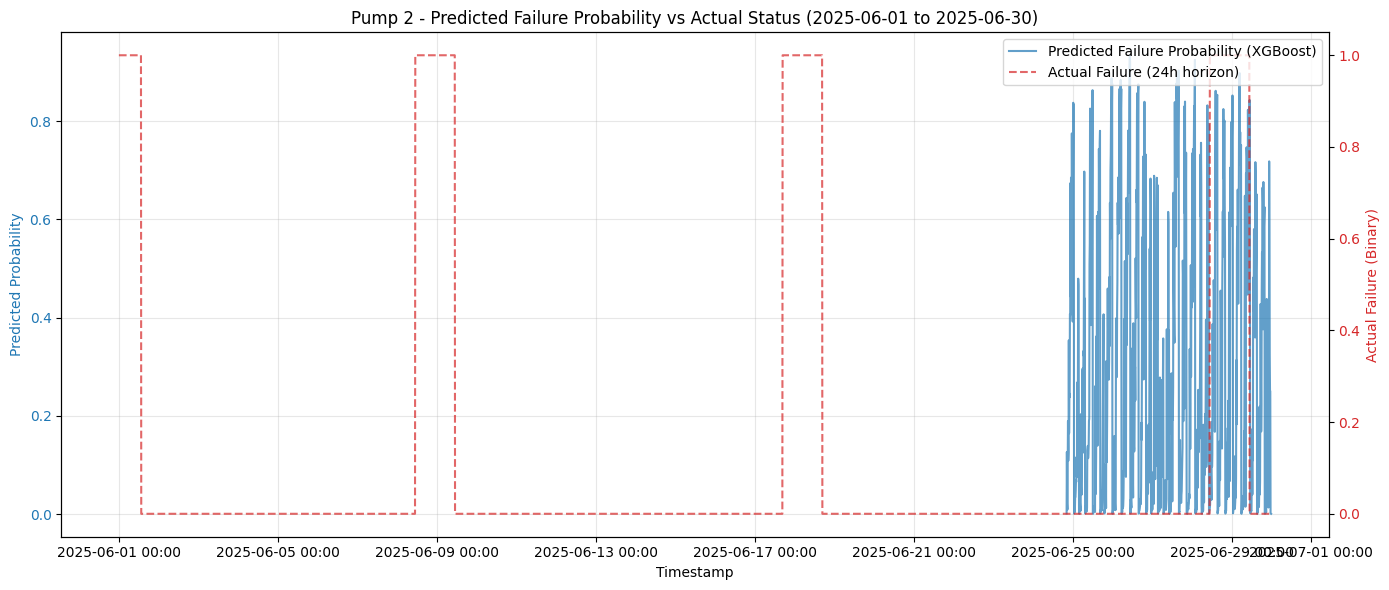

In [ ]:
# Plot actual status and predicted probability
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot predicted probability on the primary y-axis
ax1.plot(pump_data['timestamp'], pump_data['proba_xgb'], color='tab:blue', label='Predicted Failure Probability (XGBoost)', alpha=0.7)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Predicted Probability', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

# Create a secondary y-axis for the actual status
ax2 = ax1.twinx()
ax2.plot(pump_data['timestamp'], pump_data['y_failure_24h'], color='tab:red', linestyle='--', label='Actual Failure (24h horizon)', alpha=0.7)
ax2.set_ylabel('Actual Failure (Binary)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Format the x-axis as dates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

plt.title(f'Pump {pump_to_visualize} - Predicted Failure Probability vs Actual Status ({start_time.date()} to {end_time.date()})')
plt.tight_layout()
plt.show()

[info] train rows used: 25,000 (FAST=True, MAX_TRAIN=25000)
[info] test rows used:  215,999

logistic regression (scaled)  [2.1s]
----------------------------------------------------------------------
pr-auc:   0.3964
roc-auc:  0.8600
accuracy: 0.7861
f1:       0.4149
precision:0.2863
recall:   0.7531

confusion matrix [tn fp; fn tp]:
[[153431  40824]
 [  5368  16376]]

classification report:
              precision    recall  f1-score   support

           0     0.9662    0.7898    0.8692    194255
           1     0.2863    0.7531    0.4149     21744

    accuracy                         0.7861    215999
   macro avg     0.6262    0.7715    0.6420    215999
weighted avg     0.8978    0.7861    0.8234    215999

hist gradient boosting  [3.5s]
----------------------------------------------------------------------
pr-auc:   0.3769
roc-auc:  0.8582
accuracy: 0.8377
f1:       0.4418
precision:0.3378
recall:   0.6381

confusion matrix [tn fp; fn tp]:
[[167062  27193]
 [  7870  13874]]

cla

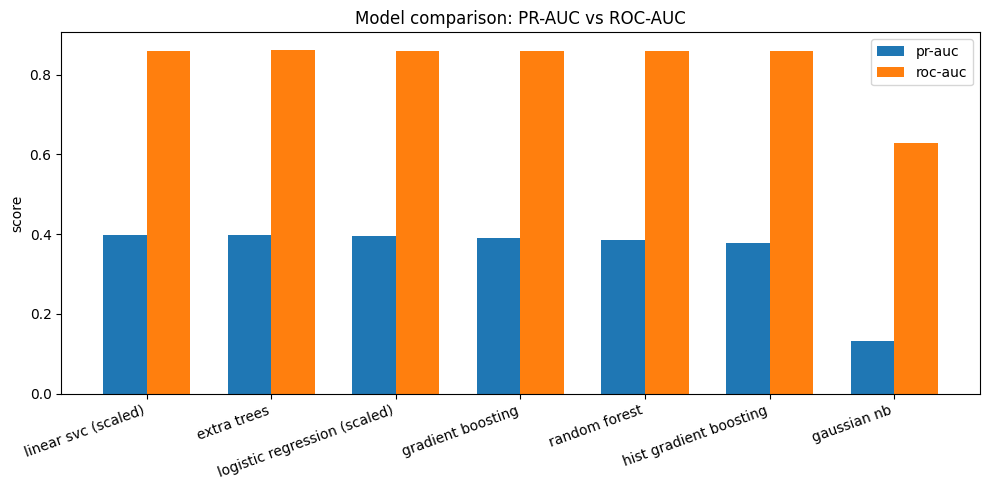

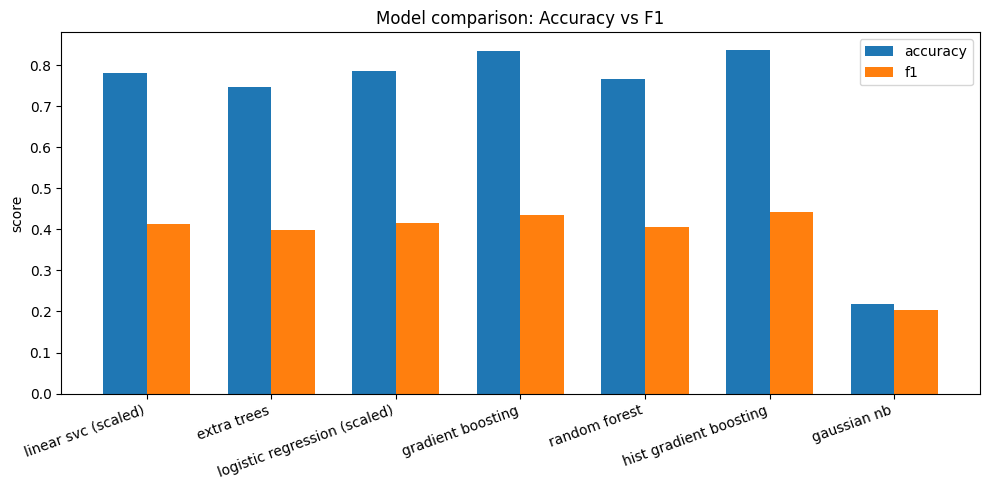

In [ ]:
# =========================================
# other models
# uses our feat_cols, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled
# this trims train (optionally), dials tree sizes down, and times each fit
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score, f1_score,
    precision_score, recall_score, classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, HistGradientBoostingClassifier
)
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# -----------------------------
# knobs
# -----------------------------
# FAST: if true, we sub-sample the training set to keep runtime predictable
#       evaluation still happens on full X_test/y_test, so comparisons are fair
FAST = True

# MAX_TRAIN: max number of training rows to keep when FAST is true
#            reduce if models still feel slow you can lower it
MAX_TRAIN = 25_000

# RANDOM_STATE: fixed seed for reproducible subsampling and model randomness
RANDOM_STATE = 42

# MODEL_SIZE: "light" = smaller/faster trees
#             "medium" = a bit heavier/slower
MODEL_SIZE = "light"   # choices: "light", "medium"

# RUN: flip which models to execute without editing code blocks
RUN = {
    "lr":   True,   # logistic regression (scaled)
    "hgb":  True,   # hist gradient boosting (light/medium)
    "rf":   True,   # random forest (light/medium)
    "gb":   True,  # classic gradient boosting (slower than hgb)
    "lsvc": True,  # linear svc (scaled) — can be slow with many features
    "et":   True,  # extra trees
    "gnb":  True,  # gaussian naive bayes (very fast baseline)
}

# -----------------------------
# model presets (size -> params)
# -----------------------------
if MODEL_SIZE == "light":
    # small + quick; good for a first pass
    RF_PARAMS  = dict(n_estimators=120, max_depth=10, max_features="sqrt",
                      min_samples_split=4, class_weight="balanced_subsample",
                      n_jobs=-1, random_state=RANDOM_STATE)
    ET_PARAMS  = dict(n_estimators=160, max_depth=12, max_features="sqrt",
                      min_samples_split=4, class_weight="balanced",
                      n_jobs=-1, random_state=RANDOM_STATE)
    GB_PARAMS  = dict(learning_rate=0.08, n_estimators=120, max_depth=3,
                      random_state=RANDOM_STATE)
    HGB_PARAMS = dict(learning_rate=0.08, max_iter=100,  # few iters
                      early_stopping=True, validation_fraction=0.1,
                      n_iter_no_change=10, random_state=RANDOM_STATE)
    LSVC_C     = 0.5
elif MODEL_SIZE == "medium":
    # a bit heavier; use when you have more time
    RF_PARAMS  = dict(n_estimators=200, max_depth=14, max_features="sqrt",
                      min_samples_split=4, class_weight="balanced_subsample",
                      n_jobs=-1, random_state=RANDOM_STATE)
    ET_PARAMS  = dict(n_estimators=300, max_depth=16, max_features="sqrt",
                      min_samples_split=4, class_weight="balanced",
                      n_jobs=-1, random_state=RANDOM_STATE)
    GB_PARAMS  = dict(learning_rate=0.06, n_estimators=250, max_depth=3,
                      random_state=RANDOM_STATE)
    HGB_PARAMS = dict(learning_rate=0.06, max_iter=160,  # more iters
                      early_stopping=True, validation_fraction=0.1,
                      n_iter_no_change=12, random_state=RANDOM_STATE)
    LSVC_C     = 1.0
else:
    raise ValueError("MODEL_SIZE must be 'light' or 'medium'.")

# -----------------------------
# prep: ensure arrays + optional sub-sample
# -----------------------------

from sklearn.preprocessing import StandardScaler

# --- Scale first ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns
)

# --- Reset indices for alignment ---
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)
X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)

# --- Convert to arrays ---
y_train_arr = y_train.to_numpy(dtype=int)
y_test_arr  = y_test.to_numpy(dtype=int)

X_train_tree = X_train.to_numpy(dtype=np.float32)
X_test_tree  = X_test.to_numpy(dtype=np.float32)
X_train_scaled_arr = X_train_scaled.to_numpy(dtype=np.float64)
X_test_scaled_arr  = X_test_scaled.to_numpy(dtype=np.float64)

# --- Subsample the training set if FAST is True ---
# -----------------------------
# Prepare subsampled train & aligned test
# -----------------------------
if FAST:
    rng = np.random.RandomState(RANDOM_STATE)
    pos_idx = np.where(y_train_arr == 1)[0]
    neg_idx = np.where(y_train_arr == 0)[0]

    take_pos = min(len(pos_idx), MAX_TRAIN // 3)
    take_neg = min(len(neg_idx), MAX_TRAIN - take_pos)

    pos_take = rng.choice(pos_idx, size=take_pos, replace=False)
    neg_take = rng.choice(neg_idx, size=take_neg, replace=False)

    sub_idx = np.sort(np.concatenate([pos_take, neg_take]))
    Xtr = X_train.iloc[sub_idx].reset_index(drop=True)
    ytr = y_train.iloc[sub_idx].reset_index(drop=True)
else:
    Xtr = X_train.reset_index(drop=True)
    ytr = y_train.reset_index(drop=True)

# aligned test set
X_test_safe = X_test.reset_index(drop=True)
y_test_safe = y_test.reset_index(drop=True)

# for tree models
Xtr_tree = Xtr.to_numpy(dtype=np.float32)
X_test_tree = X_test_safe.to_numpy(dtype=np.float32)
ytr_arr = ytr.to_numpy(dtype=int)
y_test_arr = y_test_safe.to_numpy(dtype=int)

print(f"[info] train rows used: {len(ytr):,} (FAST={FAST}, MAX_TRAIN={MAX_TRAIN})")
print(f"[info] test rows used:  {len(y_test_arr):,}\n")


# -----------------------------
# helpers: scoring + reporting
# -----------------------------
def _score_vector(estimator, X):
    """
    Returns a continuous score for PR/ROC curves.
    Handles pipelines and chooses the best available method:
    - predict_proba if available
    - decision_function if available
    - fallback to predict otherwise
    """
    # If estimator is a pipeline, get the final step
    # Do NOT strip the pipeline; call estimator directly
    if hasattr(estimator, "predict_proba"):
        p = estimator.predict_proba(X)
        return p[:, 1] if p.ndim == 2 else p
    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)
    return estimator.predict(X)

def _pred_labels(estimator, X, scores):
    # prefer model.predict(); otherwise use 0.5 (proba) or 0.0 (margins)
    try:
        # Direct prediction (works for pipelines and raw models)
        return estimator.predict(X)
    except Exception:
        # fallback: threshold continuous scores
        if hasattr(estimator, "predict_proba"):
            return (scores >= 0.5).astype(int)
        return (scores >= 0.0).astype(int)

def _print_block(name, y_true, scores, preds, feature_names=None, model=None, top_k=15, fit_secs=None):
    # compact metrics + little diagnostics
    pr  = average_precision_score(y_true, scores)
    roc = roc_auc_score(y_true, scores)
    acc = accuracy_score(y_true, preds)
    f1  = f1_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec  = recall_score(y_true, preds, zero_division=0)
    cm  = confusion_matrix(y_true, preds)

    print("="*70)
    print(name + (f"  [{fit_secs:.1f}s]" if fit_secs is not None else ""))
    print("-"*70)
    print(f"pr-auc:   {pr:.4f}")
    print(f"roc-auc:  {roc:.4f}")
    print(f"accuracy: {acc:.4f}")
    print(f"f1:       {f1:.4f}")
    print(f"precision:{prec:.4f}")
    print(f"recall:   {rec:.4f}")
    print("\nconfusion matrix [tn fp; fn tp]:")
    print(cm)
    print("\nclassification report:")
    print(classification_report(y_true, preds, digits=4))

    # top features (if exposed)
    if feature_names is not None and model is not None:
        if hasattr(model, "feature_importances_") and getattr(model, "feature_importances_", None) is not None:
            s = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False).head(top_k)
            print("\n(top features by importance)")
            print(s.to_string())
        elif hasattr(model, "coef_"):
            coefs = pd.Series(model.coef_.ravel(), index=feature_names)
            top = coefs.reindex(coefs.abs().sort_values(ascending=False).head(top_k).index)
            print("\n(top coefficients; standardized features)")
            print(top.to_string())

    # return row for summary
    return {"model": name, "fit_sec": float(fit_secs) if fit_secs is not None else np.nan,
            "pr_auc": float(pr), "roc_auc": float(roc),
            "accuracy": float(acc), "f1": float(f1),
            "precision": float(prec), "recall": float(rec)}

_model_results = []

# Helper function to decide feature_names automatically
def safe_feat_names(model, feat_cols):
    # Only provide feature names if lengths match
    if feat_cols is None:
        return None
    try:
        if hasattr(model, "feature_importances_") and model.feature_importances_ is not None:
            return feat_cols if len(model.feature_importances_) == len(feat_cols) else None
        if hasattr(model, "coef_"):
            return feat_cols if len(model.coef_.ravel()) == len(feat_cols) else None
    except Exception:
        return None
    return None



# -----------------------------
# 1) Logistic Regression (scaled, NaN-safe)
# -----------------------------
if RUN["lr"]:
    lr_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1500, class_weight="balanced"))
    ])
    t0 = time.time()
    lr_pipeline.fit(Xtr, ytr)
    fit_secs = time.time() - t0

    lr_scores = _score_vector(lr_pipeline, X_test_safe)
    lr_preds  = _pred_labels(lr_pipeline, X_test_safe, lr_scores)

    _model_results.append(
        _print_block("logistic regression (scaled)", y_test_safe, lr_scores, lr_preds,
                     safe_feat_names(rf, feat_cols), lr_pipeline, fit_secs=fit_secs)
    )

# -----------------------------
# 2) HistGradientBoosting (trees handle NaN natively)
# -----------------------------
if RUN["hgb"]:
    t0 = time.time()
    hgb = HistGradientBoostingClassifier(**HGB_PARAMS)
    hgb.fit(Xtr_tree, ytr_arr)
    fit_secs = time.time() - t0

    hgb_scores = _score_vector(hgb, X_test_tree)
    hgb_preds  = _pred_labels(hgb, X_test_tree, hgb_scores)

    _model_results.append(
        _print_block("hist gradient boosting", y_test_safe, hgb_scores, hgb_preds,
                     safe_feat_names(rf, feat_cols), hgb, fit_secs=fit_secs)
    )

# -----------------------------
# 3) Random Forest
# -----------------------------
if RUN["rf"]:
    t0 = time.time()
    rf = RandomForestClassifier(**RF_PARAMS)
    rf.fit(Xtr_tree, ytr_arr)
    fit_secs = time.time() - t0

    rf_scores = _score_vector(rf, X_test_tree)
    rf_preds  = _pred_labels(rf, X_test_tree, rf_scores)

    _model_results.append(
        _print_block("random forest", y_test_safe, rf_scores, rf_preds,
                     safe_feat_names(rf, feat_cols), rf, fit_secs=fit_secs)
    )

# -----------------------------
# 4) Gradient Boosting
# -----------------------------
if RUN["gb"]:
    t0 = time.time()
    gb_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", GradientBoostingClassifier(**GB_PARAMS))
    ])

    gb_pipeline.fit(Xtr, ytr)
    gb_scores = _score_vector(gb_pipeline, X_test_safe)
    gb_preds  = _pred_labels(gb_pipeline, X_test_safe, gb_scores)

    _model_results.append(
        _print_block("gradient boosting", y_test_safe, gb_scores, gb_preds,
                     safe_feat_names(rf, feat_cols), gb, fit_secs=fit_secs)
    )

# -----------------------------
# 5) Linear SVC (scaled, NaN-safe)
# -----------------------------
if RUN["lsvc"]:
    lsvc_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LinearSVC(C=LSVC_C, class_weight="balanced",
                            max_iter=3000, random_state=RANDOM_STATE))
    ])
    t0 = time.time()
    lsvc_pipeline.fit(Xtr, ytr)
    fit_secs = time.time() - t0

    lsvc_scores = _score_vector(lsvc_pipeline, X_test_safe)
    lsvc_preds  = _pred_labels(lsvc_pipeline, X_test_safe, lsvc_scores)

    _model_results.append(
        _print_block("linear svc (scaled)", y_test_safe, lsvc_scores, lsvc_preds,
                     safe_feat_names(rf, feat_cols), lsvc_pipeline, fit_secs=fit_secs)
    )

# -----------------------------
# 6) Extra Trees
# -----------------------------
if RUN["et"]:
    t0 = time.time()
    et = ExtraTreesClassifier(**ET_PARAMS)
    et.fit(Xtr_tree, ytr_arr)
    fit_secs = time.time() - t0

    et_scores = _score_vector(et, X_test_tree)
    et_preds  = _pred_labels(et, X_test_tree, et_scores)

    _model_results.append(
        _print_block("extra trees", y_test_safe, et_scores, et_preds,
                     safe_feat_names(rf, feat_cols), et, fit_secs=fit_secs)
    )

# -----------------------------
# 7) Gaussian Naive Bayes (scaled, NaN-safe)
# -----------------------------
if RUN["gnb"]:
    gnb_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", GaussianNB())
    ])
    t0 = time.time()
    gnb_pipeline.fit(Xtr, ytr)
    fit_secs = time.time() - t0

    gnb_scores = _score_vector(gnb_pipeline, X_test_safe)
    gnb_preds  = _pred_labels(gnb_pipeline, X_test_safe, gnb_scores)

    _model_results.append(
        _print_block("gaussian nb", y_test_safe, gnb_scores, gnb_preds,
                     safe_feat_names(rf, feat_cols), gnb_pipeline, fit_secs=fit_secs)
    )


# -----------------------------
# summary table + dynamic plots
# -----------------------------
summary_df = pd.DataFrame(_model_results).sort_values("pr_auc", ascending=False).reset_index(drop=True)

print("="*70)
print("summary by model (sorted by pr-auc)")
print("-"*70)
print(summary_df.to_string(index=False))

# Dynamic bar positions
num_models = len(summary_df)
x = np.arange(num_models)
w = 0.35  # bar width

# 1) PR-AUC vs ROC-AUC
plt.figure(figsize=(10, 5))
plt.bar(x - w/2, summary_df["pr_auc"].values, w, label="pr-auc")
plt.bar(x + w/2, summary_df["roc_auc"].values, w, label="roc-auc")
plt.xticks(x, summary_df["model"].tolist(), rotation=20, ha="right")
plt.ylabel("score")
plt.title("Model comparison: PR-AUC vs ROC-AUC")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Accuracy vs F1
plt.figure(figsize=(10, 5))
plt.bar(x - w/2, summary_df["accuracy"].values, w, label="accuracy")
plt.bar(x + w/2, summary_df["f1"].values, w, label="f1")
plt.xticks(x, summary_df["model"].tolist(), rotation=20, ha="right")
plt.ylabel("score")
plt.title("Model comparison: Accuracy vs F1")
plt.legend()
plt.tight_layout()
plt.show()

